# DataLoaders

In [35]:
import numpy as np
import os
import json
from torch.utils.data import Dataset
np.set_printoptions(suppress = True)

class FireDataLoader(Dataset):
    """
    DataLoader for Fire Dataset.

    Methods:
    ________
    get_time(index)
        Helper method to get the year, month, and day from teh file name

    get_xy(index)
        Helper method to get the coordinate x, y from the file names

    __loadjson_statistics(root)
        Private method to get the statistics of the dataset from the root directory

    __getpath(root)
        Private method to get the files names with corresponding labels of the dataset inside the root directory

    __loadnpy(npy_file)
        Private method to get data by file path

    min_max_scale(array, min_alt, max_alt, min_new, max_new)
        Helper method to normalize an array between new minimum and maximum values
    """

    def __init__(self, root: str, mode: str = 'train', is_scale: bool = True,
                 neg_pos_ratio: int | None = 2, val_year: int = 2019,
                 val_span: int = 2,
                 negative: str = 'clc', nan_fill: float = 0., is_aug: bool = False,
                 is_shuffle: bool = True, lag: int = 10,
                 static_features: list = None, dynamic_features: list = None,
                 seed: int = 0):
        super (FireDataLoader, self).__init__()
        """
        Parameters:
        -----------
        root: Root Directory 
        mode: specifies dataset split "train","val" or "test"
        is_scale: Whether to apply normalization (min-max scaling) to data arrays from mean_std_train.json.
        neg_pos_ratio: Ratio of negative samples to positive samples. How many negative samples to draw per positive (class balancing). If 2, you'll get ~2x as many negatives as positive for the splits.
        val_year: Year used for validation split - earlier years are for training, later for testing.
        nan_fill: value to replace missing entries in the data arrays.
        is_agu: Enables data augmentation
        is_shuffle: Whether to shuffle the list of file samples at initialization
        lag: Number of days (temporal length to load for dynamic features.
        static_features: Name of the static features
        dynamic_features: Name of the time dependent (dynamic) features
        seed:Random seed for reproducibility when sampling negatives
        """
        self.root = root
        self.mode = mode
        self.lag = lag
        self.is_scale = is_scale
        self.is_aug = is_aug
        self.shuffle = is_shuffle
        self.nan_fill = nan_fill
        self.val_year = val_year
        self.val_span = val_span
        self.neg_pos_ratio = neg_pos_ratio
        self.seed = seed
        self.static_features = static_features
        self.dynamic_features = dynamic_features
        self.__leap_year = [0,31,60,91,121,152,182,213,244,274,305,335]
        assert mode in ['train', 'test', 'val']
        self.__getpath(self.root)
        self.__loadjson_statistic(root)

        if is_shuffle:
            np.random.shuffle(self.files)

    def get_time(self, index: int):
        """
        Helper method to get the year, month and day from the file name

        Parameters
        ----------
        index: int
            The index of the file
        Returns
        -------
        year: int, month: int, day: int
        """
        assert index < len(self.files)
        name = os.path.basename(os.path.normpath(self.files[index][0]))
        return int(name[:4]), int(name[4:6]), int(name[6:8])

        
    def get_xy(self, index):
        """
        Helper method to get the coordinate x, y from the file name

        Parameters
        ----------
        index : int
            The index of the file

        Returns
        ----------
        x: int, y: int
        """
        assert index < len(self.files)
        name = os.path.basename(os.path.normpath(self.files[index][0]))[9:]
        ind = name.find('_')
        return int(name[:ind]), int(name[ind+1:])   

    def __loadnpy(self, npy_file):
        """
        Private method to get data by file path

        Parameters
        ----------
        npy_file: str (Path to file)

        Returns
        -------
        array_dynamic: numpy array (dynamic features)
        array_static: numpy array (static features)
        array_clc_vec: numpy array (fractio of classes)
        array_clc_mode: numpy array CORINE Land Cover
        """
        arr_dyn_raw = np.load(npy_file + '_dynamic.npy')         
        arr_stat_raw = np.load(npy_file + '_static.npy')         
        arr_clc_raw = np.load(npy_file + '_clc_vec.npy')          
        array_dynamic = np.load(npy_file + '_dynamic.npy')[:, self.dynamic_features_ind, :, :]
        array_static = np.load(npy_file + '_static.npy')[self.static_features_ind, :, :]
        array_clc_vec = np.load(npy_file + '_clc_vec.npy')[:, :, :]
        # Originally the data is in chronological order (from earliest day -> latest day). It is 
        # reversed so that index 0 corresponds to the latest day and the later indices go backward in time.
        array_dynamic = np.flip(array_dynamic, axis = 0)
        # The model doesn't use all historical days but only takes a fixed window of the days.
        array_dynamic = array_dynamic[:self.lag, :, :, :]
        # After slicing, the shape is [lag, C, H, W] time as teh first axis, channels as second.
        # Most deep learning models expect input with channels first then time so swapaxes
        # switches those two axes.
        array_dynamic = np.swapaxes(array_dynamic, 0, 1)
        return array_dynamic, array_static, array_clc_vec

    def __loadjson_statistic(self, root):
        """
        Private method to get the statistics of the dataset from the root directory
        Parameters
        ----------
        root: str
            Directory to dataset
        """
        with open(os.path.join(root, "statistics.json"), 'r') as file:
            dict = json.load(file)
            self.min_static, self.min_dynamic = [],[]
            self.max_static, self.max_dynamic = [],[]
            self.static_features_ind, self.dynamic_features_ind = [],[]

            for feature in ['static', 'dynamic']:
                # Here This is not looping over the numerical values, code is looping our hte feature names keys contained inside the mean dictionar.
                for i, f in enumerate(dict[feature]['min'].keys()):
                    if feature == 'static':
                        if f in self.static_features:
                            self.min_static.append(dict[feature]['min'][f])
                            self.max_static.append(dict[feature]['max'][f])
                            self.static_features_ind.append(i)
                    else:
                        if f in self.dynamic_features:
                            self.min_dynamic.append(dict[feature]['min'][f])
                            self.max_dynamic.append(dict[feature]['max'][f])
                            self.dynamic_features_ind.append(i)
                            
    def __getpath(self, root):
        """
        Private method to get the files names with corresponding labels of the dataset inside the root directory.
        Parameters
        ----------
        root: str
            Directory to dataset
        """
        dirs = [["positive",1],['negative',0]]
        self.files = []
        for dir, label in dirs:
            path = os.path.join(root,dir)
            files = os.listdir(path)
            if self.mode == "train":
                files = [file for file in files if int(file[:4]) < self.val_year]
            elif self.mode == "val":
                files = [file for file in files if int(file[:4]) == self.val_year]
            else:
                files = [file for file in files if int(file[:4]) > self.val_year]
            files.sort()
            files = [(os.path.join(path, file[:-12]), label) for file in files if file.endswith('dynamic.npy')]
            if self.neg_pos_ratio and label < 1 and self.mode == "train":
                assert len(self.files) * self.neg_pos_ratio <= len(files)
                np.random.seed(self.seed)
                indices_random = np.random.choice(len(files), len(self.files)*self.neg_pos_ratio, replace=False)
                files = [files[index] for index in indices_random]
            self.files += files

    def min_max_scale(self, array: np.array,
                      min_alt: float, max_alt: float,
                      min_new: float = 0., max_new: float = 1.):
        """
        Helper method to normalize an array between new minimum and maximum values
        Parameters
        ----------
        array : numpy array
            array to be normalized
        min_alt : float
            minimum value in array
        max_alt : float
            maximum value in array
        min_new : float
            minimum value after normalization
        max_new : float
            maximum value after normalization
        Returns
        ----------
       array : numpy array
            normalized numpy array
        """
        array = ((max_new - min_new) * (array - min_alt) / (max_alt - min_alt)) + min_new
        return array

    def __getitem__(self, index):
        """
        Method to get data by index

        Parameters
        ----------
        index: intsmi
            The index of the file
        Returns
        -------
        data_static: numpy array
            static features
        data_dynamic: numpy array
            dynamic features
        data_clc: numpy array
            fraction of classes
        label: numpy array
            labels (positive 1, negative 0)
        data_mode: numpy array
            land cover with the main 10 classes
        data_time: int
            day of the year
        """
        # get file names and labels
        file_path, label = self.files[index]
        data_dynamic, data_static, data_clc = self.__loadnpy(file_path)

        if self.is_scale:
            for d in range(len(data_dynamic)):
                data_dynamic[d, :, :, :] = self.min_max_scale(data_dynamic[d, :, :, :], self.min_dynamic[d], self.max_dynamic[d])                
            for s in range(len(data_static)):
                data_static[s, :, :] = self.min_max_scale(data_static[s, :, :], self.min_static[s], self.max_static[s])  

        if self.is_aug:
            is_noise = np.random.choice(np.arange(0,2), p=[0.5,0.5])
            if is_noise:
                data_static = data_static + np.random.randn(data_static.shape[0],
                              data_static.shape[1],
                              data_static.shape[2]).astype(np.float64) * 0.01

                data_dynamic = data_dynamic + np.random.randn(data_dynamic.shape[0],
                              data_dynamic.shape[1],
                              data_dynamic.shape[2],
                              data_dynamic.shape[3]).astype(np.float64) * 0.01
            is_rotate = np.random.choice(np.arange(0,2), p=[0.5,0.5])
            if is_rotate:
                k = np.random.randint(1,4)
                data_static = np.rot90(data_static, k = k, axes=(-1,-2))
                data_dynamic = np.rot90(data_dynamic, k=k, axes=(-1,-2))
                data_clc = np.rot90(data_clc, k=k, axes=(-1,-2))

            is_flip = np.random.choice(np.arange(0,2), p=[0.5,0.5])
            if is_flip:
                ax = np.random.randint(1,2)
                data_static = np.flip(data_static, axis=-ax)
                data_dynamic = np.flip(data_dynamic,axis=-ax)
                data_clc = np.flip(data_clc, axis=-ax)

            is_transpose = np.random.choice(np.arange(0,2), p=[0.5,0.5])
            if is_transpose:
                data_static = np.swapaxes(data_static, -1, -2)
                data_dynamic = np.swapaxes(data_dynamic, -1, -2)
                data_clc = np.swapaxes(data_clc, -1, -2)

        data_static[np.isnan(data_static)] = self.nan_fill
        data_dynamic[np.isnan(data_dynamic)] = self.nan_fill
        data_clc[np.isnan(data_clc)] = self.nan_fill

        data_dynamic = data_dynamic.astype(np.float64)
        data_static = data_static.astype(np.float64)
        data_clc = data_clc.astype(np.float64)

        label = np.array(label)

        year, month, day = self.get_time(index)
        data_time = self.__leap_year[month-1] + day

        return data_static.copy(), data_dynamic.copy(), data_clc.copy(), label.copy(), data_time

    def __len__(self):
        """
        get number of files
        """
        return len(self.files)

In [36]:
root = "./output_aligned_patches"
dynamic_features = [
    'relative_humidity',
    'total_precipitation',
    'dew_point_temperature',
    'wind_speed',
    'temperature'
]
static_features = [
    'elevation',
    'slope',
    'population',
    'water_proximity',
    'road_proximity'
]
clc_features = ["Water", "Ice/Snow", "Built-up Open/low","Built-up(medium/high)","Barren","Forest","Shrub/Scrub","Grass/pasture/Hay","Clutivated Crops","Wetlands"]
traindata = FireDataLoader(root=root, mode='train', is_scale=True, neg_pos_ratio=1, val_year=2021, val_span=2, negative='random',
                          nan_fill=0.0, is_aug=True, is_shuffle=False, lag=10, dynamic_features=dynamic_features,
                          static_features=static_features, seed=0)
testdata = FireDataLoader(root=root, mode='val', is_scale=True, neg_pos_ratio=1, val_year=2021,val_span=2, negative='random',
                          nan_fill=0.0, is_aug=True, is_shuffle=False, lag=10, dynamic_features=dynamic_features,
                          static_features=static_features, seed=0)
validdata = FireDataLoader(root=root, mode='test', is_scale=True, neg_pos_ratio=1, val_year=2021, val_span=2, negative='random',
                          nan_fill=0.0, is_aug=True, is_shuffle=False, lag=10, dynamic_features=dynamic_features,
                          static_features=static_features, seed=0)

print('number of sampled data:', traindata.__len__())
print('number of sampled data:', validdata.__len__())
print('number of sampled data:', testdata.__len__())

# print('static data [0] shape:', data.__getitem__(0)[0].shape)
# print('dynamic data [0] shape:', data.__getitem__(0)[1].shape)
# print('clc data [0] shape:', data.__getitem__(0)[2].shape)
# print('label [0]:', data.__getitem__(0)[3])
# print('time [0]:', data.__getitem__(0)[4])
is_plot = True
is_test_run = True

if is_test_run:
    import torch
    import time
    import random
    manual_seed = 0
    random.seed(manual_seed)
    torch.manual_seed(manual_seed)
    torch.cuda.manual_seed_all(manual_seed)
    train_loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True, pin_memory= False)
    end = time.time()
    for i, (data_static, data_dynamic, data_clc, label, data_time) in enumerate(train_loader):
        print('time: {}/{}--{}'.format(i+1, len(train_loader), time.time() - end))
        end = time.time()

if is_plot:
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np

    # colormaps
    colormap_s = ['terrain', 'viridis', 'nipy_spectral', 'turbo', 'jet']
    colormap_d = ['Spectral_r', 'Reds', 'Reds', 'PuBuGn', 'Blues', 'Spectral', 'PRGn', 'PRGn', 'PuBuGn', 'PuBuGn']
    colormap_c = [
        'PuRd', 'Purples', 'YlOrBr', 'Oranges', 'copper',
        'pink', 'Greens', 'Greens', 'Greens', 'Blues'
    ]
    classes = ['negative', 'positive']

    for i in range(len(data)):
        # load one sample
        data_static, data_dynamic, data_clc, label, _ = data[int(i)]
        year, month, day = data.get_time(int(i))
        long, lat = data.get_xy(int(i))

        print(f"Time: {year}-{month}-{day} _ {classes[label]} class")

        # build a single list of colormaps for all features
        colormap_sc = colormap_s + colormap_c + colormap_d

        # T = number of days in dynamic (e.g. 10)
        T = data_dynamic.shape[1]

        # repeat static and clc over time so they match dynamic [C, T, H, W]
        data_static_rep = np.repeat(data_static[:, np.newaxis, :, :], T, axis=1)
        data_clc_rep    = np.repeat(data_clc[:,  np.newaxis, :, :], T, axis=1)

        # concatenate: [static features] + [clc features] + [dynamic features]
        data_features = np.concatenate((data_static_rep, data_clc_rep, data_dynamic), axis=0)
        names_features = static_features + clc_features + dynamic_features

        for feature_ind in range(data_features.shape[0]):
            data_f = data_features[feature_ind, ...]   # shape: [T, H, W] right now

            fig = plt.figure()
            ax = plt.axes(projection="3d")

            # figure out if this feature is CLC
            n_static = len(static_features)
            n_clc = len(clc_features)
            is_clc_feature = (feature_ind >= n_static) and (feature_ind < n_static + n_clc)

            # compute min/max BEFORE we swap axes
            vmin = np.min(data_f)
            vmax = np.max(data_f)

            # handle constant arrays (like your Shrub/Scrub = all 1s)
            if vmin == vmax:
                if is_clc_feature:
                    # force CLC to 0–1 range so 1.0 shows up
                    norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
                else:
                    # tiny epsilon so matplotlib is happy
                    norm = matplotlib.colors.Normalize(vmin=vmin - 1e-6, vmax=vmax + 1e-6)
            else:
                norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

            # match axes to what ax.voxels expects
            # current: [T, H, W]
            # you were doing: swap H,W and then swap time
            data_f_plot = np.swapaxes(data_f, -2, -1)  # [T, W, H]
            data_f_plot = np.swapaxes(data_f_plot, 0, 1)  # [W, T, H]

            cmap = plt.cm.get_cmap(colormap_sc[feature_ind])
            colors = cmap(norm(data_f_plot))

            # create a cube of ones with same shape
            cube = ax.voxels(
                np.ones_like(data_f_plot, dtype=bool),
                facecolors=colors,
                alpha=0.9
            )

            # colorbar
            m = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
            m.set_array([])
            cbar = plt.colorbar(m, ax=ax)
            cbar.set_label(names_features[feature_ind])

            # labels, title
            ax.set(ylabel='time', xlabel='long', zlabel='lat')
            title = (
                f"feature={names_features[feature_ind]} - time={year}-{month}-{day} "
                f"- x={long}, y={lat} - {classes[label]} class"
            )
            plt.title(title)

            ticks_labels = []
            for t in range(data_f_plot.shape[1]):
                ticks_labels.append('t' if t == 0 else f"t-{t}")
            ax.set_yticklabels(ticks_labels)
            ax.set_yticks(np.arange(data_f_plot.shape[1]) + 0.5)

            # clean grid/ panes
            ax.grid(False)
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

            ax.xaxis.pane.set_edgecolor('w')
            ax.yaxis.pane.set_edgecolor('w')
            ax.zaxis.pane.set_edgecolor('w')

            ax.tick_params(axis='x', colors='w')
            ax.tick_params(axis='z', colors='w')

            # hide x and z ticks numbers
            for axis in [ax.xaxis, ax.zaxis]:
                axis.set_ticks([])

            plt.show()

number of sampled data: 3870
number of sampled data: 3303
number of sampled data: 1603


NameError: name 'data' is not defined

# Loss Function


## Negative Log Likelihood
NLL loss is commonly used in classification tasks where the model outputs log-probabilities over discrete classes.
Why the paper use the NLL loss function (Chatgpt answer):
1. Binary Classification
   * The dataset is composed of positive and negative samples. The label is binary (0 or 1).
   * NLL is a standard loss for classification.
    
2. Probabilistic interpretation / calibrated predictions
    * Using NLL encourages the model to ouptut well calibrated probability estimates.
    * In wildfire forecasting, knowing how probable a fire is valuable for risk assessment and decision support.

3. Better Gradient behavior / stability
    * The log scale in NLL diminishes the effect of very low probabilities ensuring the gradient is well behaved for misclassified samples.
    * It punishes confident wrong predictions heavily, which can drive the model to correct mistakes more aggressively.

4. Consistency with probabilistic modeling literature
    * Many prior works in environmental modeling or spatio-temporal prediction use probabilistic losses.

In [3]:
import torch.nn as nn

class NLLLoss(nn.Module):
    def __init__(self, weight=None):
        super(NLLLoss, self).__init__()
        self.loss = nn.NLLLoss(weight = weight)

    def forward(self, pred, target):
        return self.loss(pred, target)

# CNN Model

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.autograd import Variable
np.set_printoptions(suppress=True, precision=2)

class Conv3D_Block(nn.Module):
    def __init__(self, in_channels: int = 18, out_channels: int=32, kernel_size:int = (3,3,3), stride:int=(1,1,1), padding:int = (1,1,1), bias:bool=True, norm:bool=True):
        super(Conv3D_Block, self).__init__()
        if norm: 
            self.Block = nn.Sequential(
                nn.Conv3d(in_channels=in_channels, out_channels= out_channels, kernel_size=kernel_size, stride = stride, padding=padding, bias=bias),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace = True)
            )
        else:
            self.Block = nn.Sequential(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels,kernel_size=kernel_size, stride = stride, padding=padding, bias=bias),
            )
    def forward(self, x:torch.Tensor):
        return self.Block(x)


class Conv2D_Block(nn.Module):
    def __init__(self, in_channels:int = 18, out_channels:int = 32, kernel_size: int=(3,3),
                 stride:int = (1,1), padding:int= (1,1), bias: bool = True, norm:bool = True):
        super(Conv2D_Block, self).__init__()
        if norm: 
            self.Block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels= out_channels, kernel_size = kernel_size,
                          stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.Block = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,kernel_size = kernel_size, stride=stride, padding=padding, bias=bias),
            )
    def forward(self, x:torch.Tensor):
        return self.Block(x)

class LOAN(nn.Module):
    def __init__(self, in_channels:int, cond_channels: int, free_norm: str = "batch", kernel_size: int=3, norm:bool = True):
        super(LOAN, self).__init__()

        self.in_channels = in_channels
        self.cond_channels = cond_channels
        self.kernel_size = kernel_size
        self.norm = norm
        self.k_channels = cond_channels

        if norm:
            if free_norm == 'batch':
                self.free_norm = nn.BatchNorm3d(self.in_channels, affine=False)
            else:
                raise ValueError('%s is not a recognized free_norm type in SPADE' % free_norm)

        self.mlp_gamma = nn.Conv2d(self.k_channels, self.in_channels, kernel_size=self.kernel_size,
                                   padding=self.kernel_size // 2)
        self.mlp_beta = nn.Conv2d(self.k_channels, self.in_channels, kernel_size=self.kernel_size,
                                  padding=self.kernel_size // 2)
        
        self.mlp_beta.apply(self.init_weights)
        self.mlp_gamma.apply(self.init_weights)
        self.free_norm_cond = torch.nn.BatchNorm2d(cond_channels, affine=False)

    def init_weights(self, m):
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.normal_(m.weight.data, 0.0, 0.01)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x:torch.Tensor, con_map: torch.Tensor):
        """
        input tensor x [N, K, D, W, H]
        conditional map tensor con_map (N, K, W, H]
        """
        if self.norm:
            normalized = self.free_norm(x)
        else:
            normalized = x

        actv = self.free_norm_cond(con_map)
        actv = nn.functional.relu(actv)
        gamma = self.mlp_gamma(actv)
        beta = self.mlp_beta(actv)
        out = normalized * (1 + gamma[:, :, None, :, :]) + beta[:, :, None, :, :]
        return out

class CNN(nn.Module):
    def __init__(self, input_channels_d:int=10, input_channels_s = 5, input_channels_c: int = 10, 
                 n_classes: int = 2, drop_out: float = 0.3, pe: bool = True, device: str = 'cuda'):
        super(CNN, self).__init__()
        """
        Parameters
        ----------
        input_channels_d : int (default 10)
            number of input dynamic feature Vd
        input_channels_s : int (default 5)
            number of input static features
        input_channels_c : int (default 10)
            number of input land cover features
        n_classes: int (default 2)
            number of classes
        drop_out: float (default 0.5)
            dropout ratio
        pe: bool (default True)
            option to use positional encoding
        device: str (default cuda)
            device GPU Or CUDA
        """
        self.input_channels_d = input_channels_d
        self.input_channels_s = input_channels_s
        self.input_channels_c = input_channels_c

        self.drop_out = drop_out

        self.n_classes = n_classes
        self.pe = pe
        self.device = device

        cond_channels = 32

        self.Block1 = Conv3D_Block(self.input_channels_d,32, (2,2,2), (1,1,1), (0,0,0), True, False)
        self.loan1 = LOAN(in_channels = 32, cond_channels = cond_channels, free_norm="batch", kernel_size=3)
        self.pool1 = nn.MaxPool3d(kernel_size=(2,1,1), stride = (2,1,1))

        cond_channels = 64

        self.Block2 = Conv3D_Block(32,64, (2,2,2),(1,1,1), (0,0,0), True, False)
        self.loan2 = LOAN(in_channels=64, cond_channels=cond_channels, free_norm='batch', kernel_size=3, norm=False)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))      

        self.Block3 = Conv3D_Block(64, 128, (2, 2, 2), (1, 2, 2), (0, 0, 0), True, False)
        self.GAP = nn.AdaptiveAvgPool3d((2, 1, 1))

        self.Block4 = Conv2D_Block(15, 32, (2, 2), (1, 1), (0, 0), True, False)
        self.bn4 = nn.BatchNorm2d(32)
        self.pool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.Block5 = Conv2D_Block(32, 64, (2, 2), (1, 1), (0, 0), True, False)
        self.pool5 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.Block6 = Conv2D_Block(64, 128, (2, 2), (2, 2), (0, 0), True, False)
        self.GAP6 = nn.AdaptiveAvgPool2d(1)

        self.lastlayer1 = nn.Conv1d(128 * 2 + 128, 256, 1)
        self.lastlayer2 = nn.Conv1d(256, 128, 1)
        self.lastlayer3 = nn.Conv1d(128, 32, 1)
        self.lastlayer4 = nn.Conv1d(32, n_classes, 1)

        self.drop = nn.Dropout(drop_out)

        self.activation = nn.LogSoftmax(dim=1)
        if pe:
            self.PositionalEncoding = PositionalEncoder(256, 366, device).to(device)
            self.PE_Weights = torch.nn.Parameter(torch.zeros(256))

    def forward(self, x_s: torch.Tensor, x_c: torch.Tensor, x_d: torch.Tensor, x_t: torch.Tensor):
        """
        input static tensor x_s [N, C, W, H]
        input land cover tensor x_c [N, C, W, H]
        input dynamic tensor x_s [N, Vd, D, W, H]
        input day of the year x_t [N]
        """
        x_s = torch.cat((x_s, x_c), dim=1)
        x_d = self.Block1(x_d)
        x_s = self.Block4(x_s)
        x_d = self.loan1(x_d, x_s)
        x_s = self.bn4(x_s)
        x_s = F.relu(x_s, inplace=True)
        x_d = F.relu(x_d, inplace = True)
        # x_d = self.pool1(x_d)
        # x_s = self.pool4(x_s)
        x_d = self.Block2(x_d)
        x_s = self.Block5(x_s)
        x_d = self.loan2(x_d, x_s)
        x_d = F.relu(x_d, inplace=True)
        x_s = F.relu(x_s, inplace=False)
        # x_d = self.pool2(x_d)
        # x_s = self.pool5(x_s)
        x_d = self.Block3(x_d)
        x_s = self.Block6(x_s)
        x_d = F.relu(x_d, inplace=True)
        x_s = F.relu(x_s, inplace=True)
        x_d = self.GAP(x_d)
        x_d = x_d.view(-1, 128 * 2, 1)
        x_s = self.GAP6(x_s)
        x_s = x_s.view(-1,128,1)

        if self.pe:
            x_t = self.PositionalEncoding(x_t)
            x_t = x_t * (1 + self.PE_Weights)
            x_d = x_d + x_t.unsqueeze(-1)

        x = torch.cat((x_d, x_s), dim=1)
        
        x = self.lastlayer1(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.lastlayer2(x)
        x = F.relu(x)
        x = self.drop(x)

        x = self.lastlayer3(x)
        x = F.relu(x)

        x = self.lastlayer4(x)

        x = torch.squeeze(x, -1)
        x = self.activation(x)
        return x

class PositionalEncoder(nn.Module):
    """Positional Encoding """
    def __init__(self, d_model:int = 256, n_days:int=366, device:str="cuda"):
        super(PositionalEncoder, self).__init__()
        self.d_model = d_model
        self.n_days = n_days
        self.device = device
    
        pe = torch.zeros(n_days, d_model).to(device)

        for pos in range(n_days):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10 **((2*i)/d_model)))
                pe[pos, i+1] = math.cos(pos / (10 ** ((2*(i+1)) / d_model)))
            self.register_buffer('pe',pe)

    def forward(self, x):
        """
        input day of the year x_t [N]
        """
        x = Variable(self.pe[x-1,:], requires_grad= False).to(self.device)
        return x

# Utilites

In [5]:
import torch
import numpy as np
import random

import os

import datetime
import logging
from torchmetrics import AUROC


def log_string(logger, str):
    logger.info(str)
    print(str)


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def make_dir(dir):
    os.makedirs(dir, exist_ok=True)


def get_logger(args, model='train'):

    if args.name is None:
        args.name = str(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

    if args.log_dir is None:
        args.log_dir = './log'

    log_dir = os.path.join(args.log_dir, args.name)
    make_dir(log_dir)

    if model == 'train':
        checkpoints_dir = os.path.join(log_dir, 'model_checkpoints/')
        make_dir(checkpoints_dir)

    logger = logging.getLogger("Trainer")
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    file_handler = logging.FileHandler('%s/log_file.txt' % log_dir)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    log_string(logger, 'Parameters ...')
    log_string(logger, args)

    return logger


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



def get_optimizer(optim_groups, optim, lr, weight_decay):

    if optim == 'Adam':
        optimizer = torch.optim.Adam(optim_groups, lr=lr, weight_decay=weight_decay, eps=1e-04)
    elif optim == 'AdamW':
        optimizer = torch.optim.AdamW(optim_groups, lr=lr, weight_decay=weight_decay)
    elif optim == 'SGD':
        optimizer = torch.optim.SGD(optim_groups, lr=lr, weight_decay=weight_decay)
    elif optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(optim_groups, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError('Unexpected optimizer {}'.format(optim))

    return optimizer


def get_learning_scheduler(optimizer, lr_scheduler, lr_step_size, lr_decay):

    if lr_scheduler == 'StepLR':
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_decay)
    else:
        raise ValueError('Unexpected learning_scheduler {}'.format(lr_scheduler))

    return lr_scheduler



class evaluator():
    def __init__(self, logger, mode):

        self.classes = ['Background', 'Wildfire']
        self.n_classes = len(self.classes)

        self.mode = mode
        self.logger = logger

        self.correct_all = 0
        self.accuracy_all = 0
        self.seen_all = 0
        self.AUROC = 0

        self.accuracy = [0 for _ in range(self.n_classes)]
        self.precision = [0 for _ in range(self.n_classes)]
        self.F1 = [0 for _ in range(self.n_classes)]
        self.iou = [0 for _ in range(self.n_classes)]

        self.weights_label = np.zeros(self.n_classes)
        self.seen_label_all = [0 for _ in range(self.n_classes)]
        self.correct_label_all = [0 for _ in range(self.n_classes)]
        self.iou_de_label_all = [0 for _ in range(self.n_classes)]
        self.predicted_label_all = [0 for _ in range(self.n_classes)]

        self.preds_prob = []
        self.targets = []

        self.AUROC_metric = AUROC(num_classes=2, task='binary')

    def get_results(self, mean_loss, best_loss):

        weights_label = self.weights_label.astype(np.float32) / np.sum(self.weights_label.astype(np.float32))
        self.accuracy_all = self.correct_all / float(self.seen_all)

        message = '-----------------   %s   -----------------\n' % self.mode

        for label in range(self.n_classes):
            self.precision[label] = self.correct_label_all[label] / float(self.predicted_label_all[label])
            self.accuracy[label] = self.correct_label_all[label] / (np.array(self.seen_label_all[label], dtype=float) + 1e-6)
            self.F1[label] = 2 * self.precision[label] * self.accuracy[label] / (self.accuracy[label] + self.precision[label])
            self.iou[label] = self.correct_label_all[label] / float(self.iou_de_label_all[label])

        for label in range(self.n_classes):
            message += 'class %s weight: %.4f, precision: %.4f, accuracy: %.4f, F1: %.4f IoU: %.4f \n' % (
                self.classes[label] + ' '*(14 - len(self.classes[label])), weights_label[label],
                self.precision[label],
                self.accuracy[label],
                self.F1[label],
                self.iou[label])

        self.AUROC = self.AUROC_metric(torch.tensor(self.preds_prob, dtype=torch.float32),
                                      torch.tensor(self.targets, dtype=torch.int32))

        message += '\n%s accuracy      : %.4f' % (self.mode, self.accuracy_all)
        message += '\n%s mean accuracy : %.4f' % (self.mode, np.mean(self.accuracy))
        message += '\n%s AUROC         : %.4f' % (self.mode, self.AUROC)
        message += '\n%s mean IoU      : %.4f' % (self.mode, np.mean(self.iou))
        message += '\n%s mean F1       : %.4f' % (self.mode, np.mean(self.F1))
        message += '\n%s mean loss     : %.4f    best mean loss     : %.4f' % (self.mode, mean_loss, best_loss)

        log_string(self.logger, message)


    def reset(self):

        self.correct_all = 0
        self.accuracy_all = 0
        self.seen_all = 0
        self.AUROC = 0

        self.accuracy = [0 for _ in range(self.n_classes)]
        self.precision = [0 for _ in range(self.n_classes)]
        self.F1 = [0 for _ in range(self.n_classes)]
        self.iou = [0 for _ in range(self.n_classes)]

        self.weights_label = np.zeros(self.n_classes)
        self.seen_label_all = [0 for _ in range(self.n_classes)]
        self.correct_label_all = [0 for _ in range(self.n_classes)]
        self.iou_de_label_all = [0 for _ in range(self.n_classes)]
        self.predicted_label_all = [0 for _ in range(self.n_classes)]

        self.preds_prob = []
        self.targets = []

    def __call__(self, pred_prob, target):

        pred = np.argmax(pred_prob, axis=1)

        correct = np.sum(pred == target)
        self.correct_all += correct
        self.seen_all += len(target)

        weights, _ = np.histogram(target, range(self.n_classes + 1))
        self.weights_label += weights

        for label in range(self.n_classes):
            self.correct_label_all[label] += np.sum((pred == label) & (target == label))
            self.seen_label_all[label] += np.sum((target == label))
            self.iou_de_label_all[label] += np.sum(((pred == label) | (target == label)))
            self.predicted_label_all[label] += np.sum(pred == label)

        self.preds_prob.extend(pred_prob[:, 1].flatten())
        self.targets.extend(target.flatten())



def save_model(model, epoch, mean_loss_train, mean_loss_val, logger, args, save_name):

    log_dir = os.path.join(args.log_dir, args.name)
    checkpoints_dir = os.path.join(log_dir, 'model_checkpoints/')
    path = os.path.join(checkpoints_dir, save_name)
    log_string(logger, 'saving model to %s' % path)

    state = {
        'epoch': epoch,
        'mean_loss_train': mean_loss_train,
        'mean_loss_validation': mean_loss_val,
        'model_state_dict': model.state_dict(),
    }

    torch.save(state, path)

# Train Model

In [6]:
import argparse
import os
import time
import importlib
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

In [23]:
import argparse
from typing import List

def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser(description="Train LOAN wildfire model")

    parser.add_argument("--model", type=str, default="CNN")
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--n_workers", type=int, default=10)
    parser.add_argument("--pin_memory", type=bool, default=True)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--name", type=str, default="train")
    parser.add_argument("--gpu_id", type=int, default=0)
    parser.add_argument("--val_year", type=int, default=2021)
    parser.add_argument("--negative", type=str, choices=["random", "clc"], default="random")
    parser.add_argument("--nan_fill", type=bool, default=True)
    parser.add_argument("--is_aug", type=bool, default=True)
    parser.add_argument("--is_scale", type=bool, default=True)
    parser.add_argument("--is_shuffle", type=bool, default=True)
    parser.add_argument("--lag", type=int, default=10)
    parser.add_argument("--neg_pos_ratio_train", type=int, default=2)
    parser.add_argument("--neg_pos_ratio_val", type=int, default=0)
    parser.add_argument("--n_epochs", type=int, default=40)
    parser.add_argument("--lr", type=float, default=0.00003)
    parser.add_argument("--optimizer", type=str, default="Adam")
    parser.add_argument("--weight_decay", type=float, default=0.02)
    parser.add_argument("--drop_out", type=float, default=0.5)
    parser.add_argument("--PE", type=bool, default=True)
    parser.add_argument("--lr_scheduler", type=str, default="StepLR")
    parser.add_argument("--lr_step_size", type=int, default=23)
    parser.add_argument("--lr_decay", type=float, default=0.1)
    parser.add_argument("--e_save", type=int, default=2)
    parser.add_argument("--data_dir", type=str, default="./output_aligned_patches")
    parser.add_argument("--log_dir", type=str, default="./log")
    parser.add_argument("--model_dir", type=str, default="log/train/model_checkpoints/best_loss_model.pth")

    parser.add_argument(
        "--dynamic_features",
        nargs="+",
        default= [
    'relative_humidity',
    'total_precipitation',
    'dew_point_temperature',
    'wind_speed',
    'temperature',
    # 'smi'
],
        help="List of dynamic feature names"
    )
    parser.add_argument(
        "--static_features",
        nargs="+",
        default=[
    'elevation',
    'slope',
    'population',
    'water_proximity',
    'road_proximity'
],
        help="List of static feature names"
    )

    parser.add_argument(
        "--clc_features",
        nargs="+",
        default= ["Water", "Ice/Snow", "Built-up Open/low","Built-up(medium/high)","Barren","Forest","Shrub/Scrub","Grass/pasture/Hay","Clutivated Crops","Wetlands"],
        help="List of land cover class features"
    )

    args = parser.parse_args([])
    return args

args = get_args()
print(args.name)

train


In [24]:
VAL_DATASET = FireDataLoader(root=args.data_dir, mode='val', is_scale=args.is_scale, neg_pos_ratio=args.neg_pos_ratio_val,
                                 val_year=args.val_year, negative=args.negative, nan_fill=args.nan_fill,
                                 is_aug=False, is_shuffle=False, lag=args.lag, dynamic_features=args.dynamic_features,
                                 static_features=args.static_features, seed=args.seed)

In [25]:
import csv

def train():
    logger = get_logger(args, model="train")

    log_dir = os.path.join(args.log_dir, args.name)
    os.makedirs(log_dir, exist_ok=True)
    csv_path = os.path.join(log_dir, "training_log.csv")

    with open(csv_path, "w", newline="") as f:
        csv_writer = csv.writer(f)

        # Hyperparameters block at the top
        csv_writer.writerow(["# Hyperparameters"])
        for k, v in sorted(vars(args).items()):
            csv_writer.writerow([k, v])

        csv_writer.writerow([])  # blank line

        # Header for per-epoch metrics
        csv_writer.writerow([
            "epoch",
            "loss_train",
            "loss_val",
            "acc_train",
            "acc_val",
            "acc_pos_train",
            "acc_pos_val",
            "prec_pos_train",
            "prec_pos_val",
            "f1_pos_train",
            "f1_pos_val",
            "auroc_train",
            "auroc_val",
        ])

    fix_seed(args.seed)
    device = "cuda"
    log_string(logger, "loading dataset....")

    TRAIN_DATASET = FireDataLoader(
        root=args.data_dir,
        mode='train',
        is_scale=args.is_scale,
        neg_pos_ratio=args.neg_pos_ratio_train,
        val_year=args.val_year,
        negative=args.negative,
        nan_fill=args.nan_fill,
        is_aug=args.is_aug,
        is_shuffle=args.is_shuffle,
        lag=args.lag,
        dynamic_features=args.dynamic_features,
        static_features=args.static_features,
        seed=args.seed
    )

    VAL_DATASET = FireDataLoader(
        root=args.data_dir,
        mode='val',
        is_scale=args.is_scale,
        neg_pos_ratio=args.neg_pos_ratio_val,
        val_year=args.val_year,
        negative=args.negative,
        nan_fill=args.nan_fill,
        is_aug=False,
        is_shuffle=False,
        lag=args.lag,
        dynamic_features=args.dynamic_features,
        static_features=args.static_features,
        seed=args.seed
    )
    
    trainDataLoader = torch.utils.data.DataLoader(
        TRAIN_DATASET,
        batch_size=args.batch_size,
        shuffle=args.is_shuffle,
        pin_memory=args.pin_memory,
        num_workers=args.n_workers
    )
    
    valDataLoader = torch.utils.data.DataLoader(
        VAL_DATASET,
        batch_size=args.batch_size,
        shuffle=False,
        pin_memory=args.pin_memory,
        num_workers=args.n_workers
    )
    
    log_string(logger, "# training samples: %d" % len(TRAIN_DATASET))
    log_string(logger, "# evaluation samples: %d" % len(VAL_DATASET))
    log_string(logger, "\nloading the model ...")

    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
    classifier = CNN(
        input_channels_d=len(args.dynamic_features),
        input_channels_s=len(args.static_features),
        input_channels_c=len(args.clc_features),
        n_classes=2,
        drop_out=args.drop_out,
        pe=args.PE,
        device=device
    ).to(device)

    log_string(logger, "model parameters: %d" % count_parameters(classifier))

    log_string(logger, "get criterion ...")
    class_weights = torch.Tensor([0.5, 0.5]).to(device)
    criterion = NLLLoss(weight=class_weights).to(device)

    log_string(logger, "get optimizer and learning rate scheduler ...")
    optimizer = get_optimizer(
        classifier.parameters(),
        args.optimizer,
        args.lr,
        args.weight_decay
    )
    lr_scheduler = get_learning_scheduler(
        optimizer,
        args.lr_scheduler,
        args.lr_step_size,
        args.lr_decay
    )

    log_string(logger, 'training on FireCube dataset ...\n')
    time.sleep(0.2)

    best_loss_train = np.inf
    best_loss_val = np.inf

    eval_train = evaluator(logger, 'Training')
    eval_val = evaluator(logger, 'Validation')

    for epoch in range(args.n_epochs):
        log_string(logger, '################# Epoch (%s/%s) #################' % (epoch + 1, args.n_epochs))
        classifier = classifier.train()
        loss_sum = 0.0
        time.sleep(0.2)

        # ------------- TRAIN LOOP -------------
        for i, (data_s, data_d, data_c, target, data_t) in tqdm(
            enumerate(trainDataLoader),
            total=len(trainDataLoader),
            smoothing=0.9,
            postfix="  training"
        ):
            optimizer.zero_grad()

            data_s = torch.Tensor(data_s).float().to(device)
            data_d = torch.Tensor(data_d).float().to(device)
            data_c = torch.Tensor(data_c).float().to(device)
            data_t = torch.Tensor(data_t).to(device)
            target = torch.Tensor(target).long().to(device)

            pred = classifier(data_s, data_c, data_d, data_t)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

            pred_prob = torch.exp(pred.detach()).cpu().numpy()
            eval_train(pred_prob, target.detach().cpu().numpy())

        mean_loss_train = loss_sum / float(len(trainDataLoader))
        eval_train.get_results(mean_loss_train, best_loss_train)

        if mean_loss_train <= best_loss_train:
            best_loss_train = mean_loss_train

        time.sleep(0.1)

        # ------------- VALIDATION LOOP -------------
        with torch.no_grad():
            classifier = classifier.eval()
            loss_sum = 0.0
            time.sleep(0.2)

            for i, (data_s, data_d, data_c, target, data_t) in tqdm(
                enumerate(valDataLoader),
                total=len(valDataLoader),
                smoothing=0.9,
                postfix="  validation"
            ):
                data_s = torch.Tensor(data_s).float().to(device)
                data_d = torch.Tensor(data_d).float().to(device)
                data_c = torch.Tensor(data_c).float().to(device)
                data_t = torch.Tensor(data_t).to(device)
                target = torch.Tensor(target).long().to(device)

                pred = classifier(data_s, data_c, data_d, data_t)
                loss = criterion(pred, target)
                loss_sum += loss.item()

                pred_prob = torch.exp(pred).cpu().numpy()
                eval_val(pred_prob, target.cpu().numpy())

            mean_loss_val = loss_sum / float(len(valDataLoader))
            eval_val.get_results(mean_loss_val, best_loss_val)

            if mean_loss_val <= best_loss_val:
                best_loss_val = mean_loss_val
                save_model(
                    classifier,
                    epoch,
                    mean_loss_train,
                    mean_loss_val,
                    logger,
                    args,
                    'best_loss_model.pth'
                )

            time.sleep(0.1)

        # save model every e_save epochs
        if epoch % args.e_save == 0:
            save_model(
                classifier,
                epoch,
                mean_loss_train,
                mean_loss_val,
                logger,
                args,
                'epoch_{}_model.pth'.format(epoch + 1)
            )

        # ------------- APPEND METRICS TO CSV -------------
        with open(csv_path, "a", newline="") as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow([
                epoch + 1,
                float(mean_loss_train),
                float(mean_loss_val),
                float(eval_train.accuracy_all),
                float(eval_val.accuracy_all),
                float(eval_train.accuracy[1]),
                float(eval_val.accuracy[1]),
                float(eval_train.precision[1]),
                float(eval_val.precision[1]),
                float(eval_train.F1[1]),
                float(eval_val.F1[1]),
                float(eval_train.AUROC),
                float(eval_val.AUROC),
            ])

        eval_train.reset()
        eval_val.reset()

        lr_scheduler.step()

In [26]:
train()

Parameters ...
Namespace(model='CNN', batch_size=64, n_workers=10, pin_memory=True, seed=0, name='train', gpu_id=0, val_year=2021, negative='random', nan_fill=True, is_aug=True, is_scale=True, is_shuffle=True, lag=10, neg_pos_ratio_train=2, neg_pos_ratio_val=0, n_epochs=40, lr=3e-05, optimizer='Adam', weight_decay=0.02, drop_out=0.5, PE=True, lr_scheduler='StepLR', lr_step_size=23, lr_decay=0.1, e_save=2, data_dir='./output_aligned_patches', log_dir='./log', model_dir='log/train/model_checkpoints/best_loss_model.pth', dynamic_features=['relative_humidity', 'total_precipitation', 'dew_point_temperature', 'wind_speed', 'temperature'], static_features=['elevation', 'slope', 'population', 'water_proximity', 'road_proximity'], clc_features=['Water', 'Ice/Snow', 'Built-up Open/low', 'Built-up(medium/high)', 'Barren', 'Forest', 'Shrub/Scrub', 'Grass/pasture/Hay', 'Clutivated Crops', 'Wetlands'])
loading dataset....
# training samples: 5805
# evaluation samples: 1603

loading the model ...
mod

100%|███████████████████████████████| 91/91 [00:01<00:00, 85.92it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.8272, accuracy: 0.0173, F1: 0.0339 IoU: 0.0173 
class Wildfire       weight: 0.3333, precision: 0.3356, accuracy: 0.9928, F1: 0.5016 IoU: 0.3348 

Training accuracy      : 0.3425
Training mean accuracy : 0.5050
Training AUROC         : 0.5636
Training mean IoU      : 0.1760
Training mean F1       : 0.2678
Training mean loss     : 0.7149    best mean loss     : inf


100%|█████████████████████████████| 26/26 [00:00<00:00, 92.89it/s,   validation]
/tmp/ipykernel_1254/347274951.py:127: RuntimeWarning: invalid value encountered in divide
  self.precision[label] = self.correct_label_all[label] / float(self.predicted_label_all[label])


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: nan, accuracy: 0.0000, F1: nan IoU: 0.0000 
class Wildfire       weight: 0.3762, precision: 0.3762, accuracy: 1.0000, F1: 0.5467 IoU: 0.3762 

Validation accuracy      : 0.3762
Validation mean accuracy : 0.5000
Validation AUROC         : 0.9204
Validation mean IoU      : 0.1881
Validation mean F1       : nan
Validation mean loss     : 0.6949    best mean loss     : inf
saving model to ./log/train/model_checkpoints/best_loss_model.pth
saving model to ./log/train/model_checkpoints/epoch_1_model.pth
################# Epoch (2/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.43it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.8881, accuracy: 0.3036, F1: 0.4525 IoU: 0.2924 
class Wildfire       weight: 0.3333, precision: 0.3987, accuracy: 0.9235, F1: 0.5570 IoU: 0.3860 

Training accuracy      : 0.5102
Training mean accuracy : 0.6136
Training AUROC         : 0.7435
Training mean IoU      : 0.3392
Training mean F1       : 0.5047
Training mean loss     : 0.6893    best mean loss     : 0.7149


100%|████████████████████████████| 26/26 [00:00<00:00, 111.29it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.9895, accuracy: 0.7540, F1: 0.8558 IoU: 0.7480 
class Wildfire       weight: 0.3762, precision: 0.7075, accuracy: 0.9867, F1: 0.8241 IoU: 0.7008 

Validation accuracy      : 0.8415
Validation mean accuracy : 0.8704
Validation AUROC         : 0.9198
Validation mean IoU      : 0.7244
Validation mean F1       : 0.8400
Validation mean loss     : 0.6672    best mean loss     : 0.6949
saving model to ./log/train/model_checkpoints/best_loss_model.pth
################# Epoch (3/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 79.38it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.8129, accuracy: 0.8667, F1: 0.8389 IoU: 0.7225 
class Wildfire       weight: 0.3333, precision: 0.6927, accuracy: 0.6010, F1: 0.6436 IoU: 0.4745 

Training accuracy      : 0.7781
Training mean accuracy : 0.7339
Training AUROC         : 0.8226
Training mean IoU      : 0.5985
Training mean F1       : 0.7413
Training mean loss     : 0.6171    best mean loss     : 0.6893


100%|█████████████████████████████| 26/26 [00:00<00:00, 98.35it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.6409, accuracy: 0.9960, F1: 0.7800 IoU: 0.6393 
class Wildfire       weight: 0.3762, precision: 0.9184, accuracy: 0.0746, F1: 0.1380 IoU: 0.0741 

Validation accuracy      : 0.6494
Validation mean accuracy : 0.5353
Validation AUROC         : 0.9039
Validation mean IoU      : 0.3567
Validation mean F1       : 0.4590
Validation mean loss     : 0.5206    best mean loss     : 0.6672
saving model to ./log/train/model_checkpoints/best_loss_model.pth
saving model to ./log/train/model_checkpoints/epoch_3_model.pth
################# Epoch (4/40) #################


100%|███████████████████████████████| 91/91 [00:00<00:00, 91.42it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.7704, accuracy: 0.9850, F1: 0.8646 IoU: 0.7615 
class Wildfire       weight: 0.3333, precision: 0.9323, accuracy: 0.4129, F1: 0.5723 IoU: 0.4009 

Training accuracy      : 0.7943
Training mean accuracy : 0.6990
Training AUROC         : 0.9126
Training mean IoU      : 0.5812
Training mean F1       : 0.7185
Training mean loss     : 0.4354    best mean loss     : 0.6171


100%|████████████████████████████| 26/26 [00:00<00:00, 110.06it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.6646, accuracy: 0.9870, F1: 0.7944 IoU: 0.6589 
class Wildfire       weight: 0.3762, precision: 0.8898, accuracy: 0.1741, F1: 0.2913 IoU: 0.1705 

Validation accuracy      : 0.6812
Validation mean accuracy : 0.5806
Validation AUROC         : 0.9345
Validation mean IoU      : 0.4147
Validation mean F1       : 0.5428
Validation mean loss     : 0.4150    best mean loss     : 0.5206
saving model to ./log/train/model_checkpoints/best_loss_model.pth
################# Epoch (5/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 80.48it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.8403, accuracy: 0.9718, F1: 0.9013 IoU: 0.8203 
class Wildfire       weight: 0.3333, precision: 0.9180, accuracy: 0.6305, F1: 0.7475 IoU: 0.5969 

Training accuracy      : 0.8581
Training mean accuracy : 0.8012
Training AUROC         : 0.9445
Training mean IoU      : 0.7086
Training mean F1       : 0.8244
Training mean loss     : 0.3689    best mean loss     : 0.4354


100%|████████████████████████████| 26/26 [00:00<00:00, 108.05it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.7494, accuracy: 0.9570, F1: 0.8406 IoU: 0.7250 
class Wildfire       weight: 0.3762, precision: 0.8681, accuracy: 0.4693, F1: 0.6093 IoU: 0.4381 

Validation accuracy      : 0.7735
Validation mean accuracy : 0.7132
Validation AUROC         : 0.9446
Validation mean IoU      : 0.5815
Validation mean F1       : 0.7249
Validation mean loss     : 0.3668    best mean loss     : 0.4150
saving model to ./log/train/model_checkpoints/best_loss_model.pth
saving model to ./log/train/model_checkpoints/epoch_5_model.pth
################# Epoch (6/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.42it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.8751, accuracy: 0.9556, F1: 0.9135 IoU: 0.8408 
class Wildfire       weight: 0.3333, precision: 0.8911, accuracy: 0.7271, F1: 0.8008 IoU: 0.6678 

Training accuracy      : 0.8794
Training mean accuracy : 0.8413
Training AUROC         : 0.9533
Training mean IoU      : 0.7543
Training mean F1       : 0.8572
Training mean loss     : 0.3297    best mean loss     : 0.3689


100%|████████████████████████████| 26/26 [00:00<00:00, 109.68it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8551, accuracy: 0.9380, F1: 0.8946 IoU: 0.8093 
class Wildfire       weight: 0.3762, precision: 0.8775, accuracy: 0.7363, F1: 0.8007 IoU: 0.6677 

Validation accuracy      : 0.8621
Validation mean accuracy : 0.8372
Validation AUROC         : 0.9510
Validation mean IoU      : 0.7385
Validation mean F1       : 0.8477
Validation mean loss     : 0.3226    best mean loss     : 0.3668
saving model to ./log/train/model_checkpoints/best_loss_model.pth
################# Epoch (7/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.17it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9010, accuracy: 0.9380, F1: 0.9191 IoU: 0.8503 
class Wildfire       weight: 0.3333, precision: 0.8649, accuracy: 0.7938, F1: 0.8278 IoU: 0.7062 

Training accuracy      : 0.8899
Training mean accuracy : 0.8659
Training AUROC         : 0.9551
Training mean IoU      : 0.7783
Training mean F1       : 0.8735
Training mean loss     : 0.2953    best mean loss     : 0.3297


100%|████████████████████████████| 26/26 [00:00<00:00, 109.27it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8774, accuracy: 0.9300, F1: 0.9029 IoU: 0.8230 
class Wildfire       weight: 0.3762, precision: 0.8711, accuracy: 0.7844, F1: 0.8255 IoU: 0.7028 

Validation accuracy      : 0.8752
Validation mean accuracy : 0.8572
Validation AUROC         : 0.9513
Validation mean IoU      : 0.7629
Validation mean F1       : 0.8642
Validation mean loss     : 0.2954    best mean loss     : 0.3226
saving model to ./log/train/model_checkpoints/best_loss_model.pth
saving model to ./log/train/model_checkpoints/epoch_7_model.pth
################# Epoch (8/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 86.89it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9234, accuracy: 0.9279, F1: 0.9256 IoU: 0.8616 
class Wildfire       weight: 0.3333, precision: 0.8544, accuracy: 0.8460, F1: 0.8502 IoU: 0.7394 

Training accuracy      : 0.9006
Training mean accuracy : 0.8870
Training AUROC         : 0.9594
Training mean IoU      : 0.8005
Training mean F1       : 0.8879
Training mean loss     : 0.2600    best mean loss     : 0.2953


100%|████████████████████████████| 26/26 [00:00<00:00, 102.26it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.9504, accuracy: 0.9010, F1: 0.9251 IoU: 0.8606 
class Wildfire       weight: 0.3762, precision: 0.8489, accuracy: 0.9221, F1: 0.8839 IoU: 0.7920 

Validation accuracy      : 0.9089
Validation mean accuracy : 0.9115
Validation AUROC         : 0.9531
Validation mean IoU      : 0.8263
Validation mean F1       : 0.9045
Validation mean loss     : 0.2504    best mean loss     : 0.2954
saving model to ./log/train/model_checkpoints/best_loss_model.pth
################# Epoch (9/40) #################


100%|███████████████████████████████| 91/91 [00:00<00:00, 94.39it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9339, accuracy: 0.9274, F1: 0.9306 IoU: 0.8703 
class Wildfire       weight: 0.3333, precision: 0.8568, accuracy: 0.8687, F1: 0.8627 IoU: 0.7586 

Training accuracy      : 0.9078
Training mean accuracy : 0.8981
Training AUROC         : 0.9628
Training mean IoU      : 0.8144
Training mean F1       : 0.8967
Training mean loss     : 0.2396    best mean loss     : 0.2600


100%|████████████████████████████| 26/26 [00:00<00:00, 106.53it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.9237, accuracy: 0.9080, F1: 0.9158 IoU: 0.8447 
class Wildfire       weight: 0.3762, precision: 0.8516, accuracy: 0.8756, F1: 0.8635 IoU: 0.7597 

Validation accuracy      : 0.8958
Validation mean accuracy : 0.8918
Validation AUROC         : 0.9538
Validation mean IoU      : 0.8022
Validation mean F1       : 0.8896
Validation mean loss     : 0.2492    best mean loss     : 0.2504
saving model to ./log/train/model_checkpoints/best_loss_model.pth
saving model to ./log/train/model_checkpoints/epoch_9_model.pth
################# Epoch (10/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.41it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9370, accuracy: 0.9269, F1: 0.9319 IoU: 0.8725 
class Wildfire       weight: 0.3333, precision: 0.8569, accuracy: 0.8755, F1: 0.8661 IoU: 0.7638 

Training accuracy      : 0.9097
Training mean accuracy : 0.9012
Training AUROC         : 0.9641
Training mean IoU      : 0.8181
Training mean F1       : 0.8990
Training mean loss     : 0.2305    best mean loss     : 0.2396


100%|████████████████████████████| 26/26 [00:00<00:00, 108.86it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.9028, accuracy: 0.9190, F1: 0.9108 IoU: 0.8362 
class Wildfire       weight: 0.3762, precision: 0.8615, accuracy: 0.8358, F1: 0.8485 IoU: 0.7368 

Validation accuracy      : 0.8877
Validation mean accuracy : 0.8774
Validation AUROC         : 0.9528
Validation mean IoU      : 0.7865
Validation mean F1       : 0.8796
Validation mean loss     : 0.2593    best mean loss     : 0.2492
################# Epoch (11/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 81.25it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9405, accuracy: 0.9315, F1: 0.9360 IoU: 0.8797 
class Wildfire       weight: 0.3333, precision: 0.8656, accuracy: 0.8822, F1: 0.8738 IoU: 0.7759 

Training accuracy      : 0.9151
Training mean accuracy : 0.9068
Training AUROC         : 0.9671
Training mean IoU      : 0.8278
Training mean F1       : 0.9049
Training mean loss     : 0.2221    best mean loss     : 0.2305


100%|████████████████████████████| 26/26 [00:00<00:00, 104.61it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.9165, accuracy: 0.9110, F1: 0.9137 IoU: 0.8412 
class Wildfire       weight: 0.3762, precision: 0.8539, accuracy: 0.8624, F1: 0.8581 IoU: 0.7514 

Validation accuracy      : 0.8927
Validation mean accuracy : 0.8867
Validation AUROC         : 0.9532
Validation mean IoU      : 0.7963
Validation mean F1       : 0.8859
Validation mean loss     : 0.2504    best mean loss     : 0.2492
saving model to ./log/train/model_checkpoints/epoch_11_model.pth
################# Epoch (12/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.48it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9457, accuracy: 0.9320, F1: 0.9388 IoU: 0.8847 
class Wildfire       weight: 0.3333, precision: 0.8679, accuracy: 0.8930, F1: 0.8803 IoU: 0.7862 

Training accuracy      : 0.9190
Training mean accuracy : 0.9125
Training AUROC         : 0.9670
Training mean IoU      : 0.8354
Training mean F1       : 0.9096
Training mean loss     : 0.2186    best mean loss     : 0.2221


100%|████████████████████████████| 26/26 [00:00<00:00, 102.62it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8996, accuracy: 0.9230, F1: 0.9112 IoU: 0.8368 
class Wildfire       weight: 0.3762, precision: 0.8666, accuracy: 0.8292, F1: 0.8475 IoU: 0.7353 

Validation accuracy      : 0.8877
Validation mean accuracy : 0.8761
Validation AUROC         : 0.9548
Validation mean IoU      : 0.7861
Validation mean F1       : 0.8793
Validation mean loss     : 0.2562    best mean loss     : 0.2492
################# Epoch (13/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 90.02it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9471, accuracy: 0.9302, F1: 0.9386 IoU: 0.8843 
class Wildfire       weight: 0.3333, precision: 0.8653, accuracy: 0.8961, F1: 0.8804 IoU: 0.7864 

Training accuracy      : 0.9189
Training mean accuracy : 0.9132
Training AUROC         : 0.9696
Training mean IoU      : 0.8353
Training mean F1       : 0.9095
Training mean loss     : 0.2113    best mean loss     : 0.2186


100%|████████████████████████████| 26/26 [00:00<00:00, 105.66it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8986, accuracy: 0.9220, F1: 0.9102 IoU: 0.8351 
class Wildfire       weight: 0.3762, precision: 0.8648, accuracy: 0.8275, F1: 0.8458 IoU: 0.7327 

Validation accuracy      : 0.8865
Validation mean accuracy : 0.8748
Validation AUROC         : 0.9545
Validation mean IoU      : 0.7839
Validation mean F1       : 0.8780
Validation mean loss     : 0.2564    best mean loss     : 0.2492
saving model to ./log/train/model_checkpoints/epoch_13_model.pth
################# Epoch (14/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 83.05it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9465, accuracy: 0.9367, F1: 0.9416 IoU: 0.8896 
class Wildfire       weight: 0.3333, precision: 0.8759, accuracy: 0.8941, F1: 0.8849 IoU: 0.7936 

Training accuracy      : 0.9225
Training mean accuracy : 0.9154
Training AUROC         : 0.9688
Training mean IoU      : 0.8416
Training mean F1       : 0.9132
Training mean loss     : 0.2120    best mean loss     : 0.2113


100%|████████████████████████████| 26/26 [00:00<00:00, 111.90it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.9036, accuracy: 0.9190, F1: 0.9113 IoU: 0.8370 
class Wildfire       weight: 0.3762, precision: 0.8618, accuracy: 0.8375, F1: 0.8495 IoU: 0.7383 

Validation accuracy      : 0.8883
Validation mean accuracy : 0.8782
Validation AUROC         : 0.9549
Validation mean IoU      : 0.7876
Validation mean F1       : 0.8804
Validation mean loss     : 0.2520    best mean loss     : 0.2492
################# Epoch (15/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.19it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9499, accuracy: 0.9364, F1: 0.9431 IoU: 0.8924 
class Wildfire       weight: 0.3333, precision: 0.8764, accuracy: 0.9013, F1: 0.8887 IoU: 0.7996 

Training accuracy      : 0.9247
Training mean accuracy : 0.9189
Training AUROC         : 0.9707
Training mean IoU      : 0.8460
Training mean F1       : 0.9159
Training mean loss     : 0.2061    best mean loss     : 0.2113


100%|████████████████████████████| 26/26 [00:00<00:00, 104.89it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.9105, accuracy: 0.9160, F1: 0.9133 IoU: 0.8404 
class Wildfire       weight: 0.3762, precision: 0.8593, accuracy: 0.8507, F1: 0.8550 IoU: 0.7467 

Validation accuracy      : 0.8915
Validation mean accuracy : 0.8834
Validation AUROC         : 0.9552
Validation mean IoU      : 0.7935
Validation mean F1       : 0.8841
Validation mean loss     : 0.2471    best mean loss     : 0.2492
saving model to ./log/train/model_checkpoints/best_loss_model.pth
saving model to ./log/train/model_checkpoints/epoch_15_model.pth
################# Epoch (16/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 88.95it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9478, accuracy: 0.9375, F1: 0.9426 IoU: 0.8914 
class Wildfire       weight: 0.3333, precision: 0.8776, accuracy: 0.8966, F1: 0.8870 IoU: 0.7970 

Training accuracy      : 0.9239
Training mean accuracy : 0.9171
Training AUROC         : 0.9719
Training mean IoU      : 0.8442
Training mean F1       : 0.9148
Training mean loss     : 0.2021    best mean loss     : 0.2061


100%|████████████████████████████| 26/26 [00:00<00:00, 108.22it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8678, accuracy: 0.9320, F1: 0.8987 IoU: 0.8161 
class Wildfire       weight: 0.3762, precision: 0.8715, accuracy: 0.7645, F1: 0.8145 IoU: 0.6870 

Validation accuracy      : 0.8690
Validation mean accuracy : 0.8483
Validation AUROC         : 0.9508
Validation mean IoU      : 0.7516
Validation mean F1       : 0.8566
Validation mean loss     : 0.2802    best mean loss     : 0.2471
################# Epoch (17/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 83.60it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9486, accuracy: 0.9390, F1: 0.9438 IoU: 0.8935 
class Wildfire       weight: 0.3333, precision: 0.8804, accuracy: 0.8982, F1: 0.8892 IoU: 0.8006 

Training accuracy      : 0.9254
Training mean accuracy : 0.9186
Training AUROC         : 0.9723
Training mean IoU      : 0.8470
Training mean F1       : 0.9165
Training mean loss     : 0.1991    best mean loss     : 0.2021


100%|█████████████████████████████| 26/26 [00:00<00:00, 95.27it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8358, accuracy: 0.9470, F1: 0.8880 IoU: 0.7985 
class Wildfire       weight: 0.3762, precision: 0.8872, accuracy: 0.6915, F1: 0.7773 IoU: 0.6357 

Validation accuracy      : 0.8509
Validation mean accuracy : 0.8193
Validation AUROC         : 0.9525
Validation mean IoU      : 0.7171
Validation mean F1       : 0.8326
Validation mean loss     : 0.3015    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_17_model.pth
################# Epoch (18/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 85.91it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9477, accuracy: 0.9367, F1: 0.9422 IoU: 0.8907 
class Wildfire       weight: 0.3333, precision: 0.8763, accuracy: 0.8966, F1: 0.8863 IoU: 0.7959 

Training accuracy      : 0.9233
Training mean accuracy : 0.9167
Training AUROC         : 0.9730
Training mean IoU      : 0.8433
Training mean F1       : 0.9143
Training mean loss     : 0.1972    best mean loss     : 0.1991


100%|█████████████████████████████| 26/26 [00:00<00:00, 97.45it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8466, accuracy: 0.9440, F1: 0.8927 IoU: 0.8061 
class Wildfire       weight: 0.3762, precision: 0.8852, accuracy: 0.7164, F1: 0.7919 IoU: 0.6555 

Validation accuracy      : 0.8584
Validation mean accuracy : 0.8302
Validation AUROC         : 0.9515
Validation mean IoU      : 0.7308
Validation mean F1       : 0.8423
Validation mean loss     : 0.2957    best mean loss     : 0.2471
################# Epoch (19/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 86.05it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9480, accuracy: 0.9413, F1: 0.9446 IoU: 0.8951 
class Wildfire       weight: 0.3333, precision: 0.8843, accuracy: 0.8966, F1: 0.8904 IoU: 0.8025 

Training accuracy      : 0.9264
Training mean accuracy : 0.9190
Training AUROC         : 0.9736
Training mean IoU      : 0.8488
Training mean F1       : 0.9175
Training mean loss     : 0.1960    best mean loss     : 0.1972


100%|█████████████████████████████| 26/26 [00:00<00:00, 92.12it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8892, accuracy: 0.9310, F1: 0.9096 IoU: 0.8342 
class Wildfire       weight: 0.3762, precision: 0.8759, accuracy: 0.8076, F1: 0.8404 IoU: 0.7247 

Validation accuracy      : 0.8846
Validation mean accuracy : 0.8693
Validation AUROC         : 0.9546
Validation mean IoU      : 0.7795
Validation mean F1       : 0.8750
Validation mean loss     : 0.2602    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_19_model.pth
################# Epoch (20/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.74it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9512, accuracy: 0.9375, F1: 0.9443 IoU: 0.8945 
class Wildfire       weight: 0.3333, precision: 0.8785, accuracy: 0.9039, F1: 0.8910 IoU: 0.8034 

Training accuracy      : 0.9263
Training mean accuracy : 0.9207
Training AUROC         : 0.9734
Training mean IoU      : 0.8489
Training mean F1       : 0.9176
Training mean loss     : 0.1960    best mean loss     : 0.1960


100%|████████████████████████████| 26/26 [00:00<00:00, 113.21it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8309, accuracy: 0.9480, F1: 0.8856 IoU: 0.7946 
class Wildfire       weight: 0.3762, precision: 0.8874, accuracy: 0.6799, F1: 0.7700 IoU: 0.6260 

Validation accuracy      : 0.8472
Validation mean accuracy : 0.8140
Validation AUROC         : 0.9523
Validation mean IoU      : 0.7103
Validation mean F1       : 0.8278
Validation mean loss     : 0.3111    best mean loss     : 0.2471
################# Epoch (21/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 85.89it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9513, accuracy: 0.9395, F1: 0.9454 IoU: 0.8964 
class Wildfire       weight: 0.3333, precision: 0.8820, accuracy: 0.9039, F1: 0.8928 IoU: 0.8064 

Training accuracy      : 0.9276
Training mean accuracy : 0.9217
Training AUROC         : 0.9755
Training mean IoU      : 0.8514
Training mean F1       : 0.9191
Training mean loss     : 0.1879    best mean loss     : 0.1960


100%|████████████████████████████| 26/26 [00:00<00:00, 108.81it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8555, accuracy: 0.9410, F1: 0.8962 IoU: 0.8119 
class Wildfire       weight: 0.3762, precision: 0.8827, accuracy: 0.7363, F1: 0.8029 IoU: 0.6707 

Validation accuracy      : 0.8640
Validation mean accuracy : 0.8387
Validation AUROC         : 0.9533
Validation mean IoU      : 0.7413
Validation mean F1       : 0.8495
Validation mean loss     : 0.2846    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_21_model.pth
################# Epoch (22/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 83.94it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9511, accuracy: 0.9447, F1: 0.9479 IoU: 0.9009 
class Wildfire       weight: 0.3333, precision: 0.8909, accuracy: 0.9028, F1: 0.8968 IoU: 0.8129 

Training accuracy      : 0.9307
Training mean accuracy : 0.9238
Training AUROC         : 0.9746
Training mean IoU      : 0.8569
Training mean F1       : 0.9224
Training mean loss     : 0.1894    best mean loss     : 0.1879


100%|████████████████████████████| 26/26 [00:00<00:00, 105.88it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8860, accuracy: 0.9330, F1: 0.9089 IoU: 0.8330 
class Wildfire       weight: 0.3762, precision: 0.8782, accuracy: 0.8010, F1: 0.8378 IoU: 0.7209 

Validation accuracy      : 0.8833
Validation mean accuracy : 0.8670
Validation AUROC         : 0.9561
Validation mean IoU      : 0.7770
Validation mean F1       : 0.8734
Validation mean loss     : 0.2544    best mean loss     : 0.2471
################# Epoch (23/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 83.90it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9525, accuracy: 0.9372, F1: 0.9448 IoU: 0.8953 
class Wildfire       weight: 0.3333, precision: 0.8783, accuracy: 0.9065, F1: 0.8922 IoU: 0.8053 

Training accuracy      : 0.9270
Training mean accuracy : 0.9218
Training AUROC         : 0.9749
Training mean IoU      : 0.8503
Training mean F1       : 0.9185
Training mean loss     : 0.1901    best mean loss     : 0.1879


100%|████████████████████████████| 26/26 [00:00<00:00, 107.38it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8643, accuracy: 0.9430, F1: 0.9020 IoU: 0.8214 
class Wildfire       weight: 0.3762, precision: 0.8887, accuracy: 0.7546, F1: 0.8161 IoU: 0.6894 

Validation accuracy      : 0.8721
Validation mean accuracy : 0.8488
Validation AUROC         : 0.9565
Validation mean IoU      : 0.7554
Validation mean F1       : 0.8591
Validation mean loss     : 0.2715    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_23_model.pth
################# Epoch (24/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.92it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9511, accuracy: 0.9442, F1: 0.9476 IoU: 0.9004 
class Wildfire       weight: 0.3333, precision: 0.8900, accuracy: 0.9028, F1: 0.8964 IoU: 0.8122 

Training accuracy      : 0.9304
Training mean accuracy : 0.9235
Training AUROC         : 0.9767
Training mean IoU      : 0.8563
Training mean F1       : 0.9220
Training mean loss     : 0.1832    best mean loss     : 0.1879


100%|████████████████████████████| 26/26 [00:00<00:00, 102.44it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8626, accuracy: 0.9420, F1: 0.9006 IoU: 0.8191 
class Wildfire       weight: 0.3762, precision: 0.8865, accuracy: 0.7512, F1: 0.8133 IoU: 0.6853 

Validation accuracy      : 0.8702
Validation mean accuracy : 0.8466
Validation AUROC         : 0.9552
Validation mean IoU      : 0.7522
Validation mean F1       : 0.8569
Validation mean loss     : 0.2758    best mean loss     : 0.2471
################# Epoch (25/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 86.81it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9515, accuracy: 0.9424, F1: 0.9469 IoU: 0.8992 
class Wildfire       weight: 0.3333, precision: 0.8869, accuracy: 0.9039, F1: 0.8953 IoU: 0.8105 

Training accuracy      : 0.9295
Training mean accuracy : 0.9231
Training AUROC         : 0.9752
Training mean IoU      : 0.8548
Training mean F1       : 0.9211
Training mean loss     : 0.1882    best mean loss     : 0.1832


100%|████████████████████████████| 26/26 [00:00<00:00, 107.69it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8640, accuracy: 0.9400, F1: 0.9004 IoU: 0.8188 
class Wildfire       weight: 0.3762, precision: 0.8835, accuracy: 0.7546, F1: 0.8140 IoU: 0.6863 

Validation accuracy      : 0.8702
Validation mean accuracy : 0.8473
Validation AUROC         : 0.9567
Validation mean IoU      : 0.7525
Validation mean F1       : 0.8572
Validation mean loss     : 0.2694    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_25_model.pth
################# Epoch (26/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 90.54it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9549, accuracy: 0.9413, F1: 0.9481 IoU: 0.9013 
class Wildfire       weight: 0.3333, precision: 0.8859, accuracy: 0.9111, F1: 0.8983 IoU: 0.8154 

Training accuracy      : 0.9313
Training mean accuracy : 0.9262
Training AUROC         : 0.9768
Training mean IoU      : 0.8584
Training mean F1       : 0.9232
Training mean loss     : 0.1833    best mean loss     : 0.1832


100%|████████████████████████████| 26/26 [00:00<00:00, 106.56it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8565, accuracy: 0.9430, F1: 0.8977 IoU: 0.8143 
class Wildfire       weight: 0.3762, precision: 0.8865, accuracy: 0.7380, F1: 0.8054 IoU: 0.6742 

Validation accuracy      : 0.8659
Validation mean accuracy : 0.8405
Validation AUROC         : 0.9566
Validation mean IoU      : 0.7443
Validation mean F1       : 0.8515
Validation mean loss     : 0.2774    best mean loss     : 0.2471
################# Epoch (27/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 80.00it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9553, accuracy: 0.9395, F1: 0.9474 IoU: 0.9000 
class Wildfire       weight: 0.3333, precision: 0.8829, accuracy: 0.9121, F1: 0.8973 IoU: 0.8137 

Training accuracy      : 0.9304
Training mean accuracy : 0.9258
Training AUROC         : 0.9770
Training mean IoU      : 0.8569
Training mean F1       : 0.9223
Training mean loss     : 0.1820    best mean loss     : 0.1832


100%|████████████████████████████| 26/26 [00:00<00:00, 104.95it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8701, accuracy: 0.9380, F1: 0.9028 IoU: 0.8228 
class Wildfire       weight: 0.3762, precision: 0.8819, accuracy: 0.7678, F1: 0.8209 IoU: 0.6962 

Validation accuracy      : 0.8740
Validation mean accuracy : 0.8529
Validation AUROC         : 0.9563
Validation mean IoU      : 0.7595
Validation mean F1       : 0.8619
Validation mean loss     : 0.2653    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_27_model.pth
################# Epoch (28/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 81.59it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9526, accuracy: 0.9452, F1: 0.9489 IoU: 0.9028 
class Wildfire       weight: 0.3333, precision: 0.8921, accuracy: 0.9059, F1: 0.8990 IoU: 0.8165 

Training accuracy      : 0.9321
Training mean accuracy : 0.9256
Training AUROC         : 0.9766
Training mean IoU      : 0.8596
Training mean F1       : 0.9239
Training mean loss     : 0.1828    best mean loss     : 0.1820


100%|████████████████████████████| 26/26 [00:00<00:00, 101.05it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8717, accuracy: 0.9380, F1: 0.9037 IoU: 0.8243 
class Wildfire       weight: 0.3762, precision: 0.8824, accuracy: 0.7711, F1: 0.8230 IoU: 0.6992 

Validation accuracy      : 0.8752
Validation mean accuracy : 0.8546
Validation AUROC         : 0.9561
Validation mean IoU      : 0.7618
Validation mean F1       : 0.8633
Validation mean loss     : 0.2651    best mean loss     : 0.2471
################# Epoch (29/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 84.59it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9540, accuracy: 0.9424, F1: 0.9481 IoU: 0.9014 
class Wildfire       weight: 0.3333, precision: 0.8875, accuracy: 0.9090, F1: 0.8981 IoU: 0.8151 

Training accuracy      : 0.9313
Training mean accuracy : 0.9257
Training AUROC         : 0.9769
Training mean IoU      : 0.8582
Training mean F1       : 0.9231
Training mean loss     : 0.1817    best mean loss     : 0.1820


100%|████████████████████████████| 26/26 [00:00<00:00, 100.14it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8611, accuracy: 0.9420, F1: 0.8997 IoU: 0.8177 
class Wildfire       weight: 0.3762, precision: 0.8861, accuracy: 0.7479, F1: 0.8112 IoU: 0.6823 

Validation accuracy      : 0.8690
Validation mean accuracy : 0.8450
Validation AUROC         : 0.9564
Validation mean IoU      : 0.7500
Validation mean F1       : 0.8554
Validation mean loss     : 0.2734    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_29_model.pth
################# Epoch (30/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 83.34it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9541, accuracy: 0.9450, F1: 0.9495 IoU: 0.9039 
class Wildfire       weight: 0.3333, precision: 0.8920, accuracy: 0.9090, F1: 0.9004 IoU: 0.8189 

Training accuracy      : 0.9330
Training mean accuracy : 0.9270
Training AUROC         : 0.9760
Training mean IoU      : 0.8614
Training mean F1       : 0.9250
Training mean loss     : 0.1844    best mean loss     : 0.1817


100%|████████████████████████████| 26/26 [00:00<00:00, 102.97it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8789, accuracy: 0.9360, F1: 0.9065 IoU: 0.8291 
class Wildfire       weight: 0.3762, precision: 0.8810, accuracy: 0.7861, F1: 0.8309 IoU: 0.7106 

Validation accuracy      : 0.8796
Validation mean accuracy : 0.8610
Validation AUROC         : 0.9562
Validation mean IoU      : 0.7698
Validation mean F1       : 0.8687
Validation mean loss     : 0.2604    best mean loss     : 0.2471
################# Epoch (31/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 82.29it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9519, accuracy: 0.9413, F1: 0.9466 IoU: 0.8986 
class Wildfire       weight: 0.3333, precision: 0.8852, accuracy: 0.9049, F1: 0.8950 IoU: 0.8099 

Training accuracy      : 0.9292
Training mean accuracy : 0.9231
Training AUROC         : 0.9774
Training mean IoU      : 0.8543
Training mean F1       : 0.9208
Training mean loss     : 0.1823    best mean loss     : 0.1817


100%|████████████████████████████| 26/26 [00:00<00:00, 103.19it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8581, accuracy: 0.9430, F1: 0.8985 IoU: 0.8157 
class Wildfire       weight: 0.3762, precision: 0.8869, accuracy: 0.7413, F1: 0.8076 IoU: 0.6773 

Validation accuracy      : 0.8671
Validation mean accuracy : 0.8421
Validation AUROC         : 0.9575
Validation mean IoU      : 0.7465
Validation mean F1       : 0.8531
Validation mean loss     : 0.2721    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_31_model.pth
################# Epoch (32/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 79.63it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9545, accuracy: 0.9424, F1: 0.9484 IoU: 0.9018 
class Wildfire       weight: 0.3333, precision: 0.8876, accuracy: 0.9101, F1: 0.8987 IoU: 0.8160 

Training accuracy      : 0.9316
Training mean accuracy : 0.9262
Training AUROC         : 0.9769
Training mean IoU      : 0.8589
Training mean F1       : 0.9235
Training mean loss     : 0.1819    best mean loss     : 0.1817


100%|████████████████████████████| 26/26 [00:00<00:00, 101.69it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8775, accuracy: 0.9380, F1: 0.9067 IoU: 0.8294 
class Wildfire       weight: 0.3762, precision: 0.8839, accuracy: 0.7828, F1: 0.8303 IoU: 0.7098 

Validation accuracy      : 0.8796
Validation mean accuracy : 0.8604
Validation AUROC         : 0.9565
Validation mean IoU      : 0.7696
Validation mean F1       : 0.8685
Validation mean loss     : 0.2614    best mean loss     : 0.2471
################# Epoch (33/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.13it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9520, accuracy: 0.9426, F1: 0.9473 IoU: 0.8999 
class Wildfire       weight: 0.3333, precision: 0.8875, accuracy: 0.9049, F1: 0.8961 IoU: 0.8118 

Training accuracy      : 0.9301
Training mean accuracy : 0.9238
Training AUROC         : 0.9770
Training mean IoU      : 0.8558
Training mean F1       : 0.9217
Training mean loss     : 0.1823    best mean loss     : 0.1817


100%|████████████████████████████| 26/26 [00:00<00:00, 105.01it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8658, accuracy: 0.9420, F1: 0.9023 IoU: 0.8220 
class Wildfire       weight: 0.3762, precision: 0.8874, accuracy: 0.7579, F1: 0.8175 IoU: 0.6914 

Validation accuracy      : 0.8727
Validation mean accuracy : 0.8499
Validation AUROC         : 0.9570
Validation mean IoU      : 0.7567
Validation mean F1       : 0.8599
Validation mean loss     : 0.2667    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_33_model.pth
################# Epoch (34/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 83.17it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9566, accuracy: 0.9450, F1: 0.9507 IoU: 0.9061 
class Wildfire       weight: 0.3333, precision: 0.8925, accuracy: 0.9142, F1: 0.9032 IoU: 0.8236 

Training accuracy      : 0.9347
Training mean accuracy : 0.9296
Training AUROC         : 0.9778
Training mean IoU      : 0.8648
Training mean F1       : 0.9270
Training mean loss     : 0.1795    best mean loss     : 0.1817


100%|████████████████████████████| 26/26 [00:00<00:00, 102.33it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8682, accuracy: 0.9420, F1: 0.9036 IoU: 0.8241 
class Wildfire       weight: 0.3762, precision: 0.8880, accuracy: 0.7629, F1: 0.8207 IoU: 0.6959 

Validation accuracy      : 0.8746
Validation mean accuracy : 0.8524
Validation AUROC         : 0.9575
Validation mean IoU      : 0.7600
Validation mean F1       : 0.8621
Validation mean loss     : 0.2650    best mean loss     : 0.2471
################# Epoch (35/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 80.86it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9533, accuracy: 0.9447, F1: 0.9490 IoU: 0.9029 
class Wildfire       weight: 0.3333, precision: 0.8914, accuracy: 0.9075, F1: 0.8994 IoU: 0.8171 

Training accuracy      : 0.9323
Training mean accuracy : 0.9261
Training AUROC         : 0.9768
Training mean IoU      : 0.8600
Training mean F1       : 0.9242
Training mean loss     : 0.1819    best mean loss     : 0.1795


100%|█████████████████████████████| 26/26 [00:00<00:00, 99.75it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8841, accuracy: 0.9380, F1: 0.9102 IoU: 0.8353 
class Wildfire       weight: 0.3762, precision: 0.8856, accuracy: 0.7960, F1: 0.8384 IoU: 0.7218 

Validation accuracy      : 0.8846
Validation mean accuracy : 0.8670
Validation AUROC         : 0.9570
Validation mean IoU      : 0.7785
Validation mean F1       : 0.8743
Validation mean loss     : 0.2579    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_35_model.pth
################# Epoch (36/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 82.08it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9559, accuracy: 0.9403, F1: 0.9480 IoU: 0.9012 
class Wildfire       weight: 0.3333, precision: 0.8844, accuracy: 0.9132, F1: 0.8986 IoU: 0.8158 

Training accuracy      : 0.9313
Training mean accuracy : 0.9267
Training AUROC         : 0.9757
Training mean IoU      : 0.8585
Training mean F1       : 0.9233
Training mean loss     : 0.1855    best mean loss     : 0.1795


100%|█████████████████████████████| 26/26 [00:00<00:00, 99.27it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8672, accuracy: 0.9400, F1: 0.9021 IoU: 0.8217 
class Wildfire       weight: 0.3762, precision: 0.8844, accuracy: 0.7612, F1: 0.8182 IoU: 0.6923 

Validation accuracy      : 0.8727
Validation mean accuracy : 0.8506
Validation AUROC         : 0.9563
Validation mean IoU      : 0.7570
Validation mean F1       : 0.8601
Validation mean loss     : 0.2671    best mean loss     : 0.2471
################# Epoch (37/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 80.12it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9512, accuracy: 0.9460, F1: 0.9486 IoU: 0.9022 
class Wildfire       weight: 0.3333, precision: 0.8931, accuracy: 0.9028, F1: 0.8980 IoU: 0.8148 

Training accuracy      : 0.9316
Training mean accuracy : 0.9244
Training AUROC         : 0.9765
Training mean IoU      : 0.8585
Training mean F1       : 0.9233
Training mean loss     : 0.1824    best mean loss     : 0.1795


100%|████████████████████████████| 26/26 [00:00<00:00, 100.54it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8421, accuracy: 0.9440, F1: 0.8901 IoU: 0.8020 
class Wildfire       weight: 0.3762, precision: 0.8838, accuracy: 0.7065, F1: 0.7853 IoU: 0.6464 

Validation accuracy      : 0.8546
Validation mean accuracy : 0.8252
Validation AUROC         : 0.9553
Validation mean IoU      : 0.7242
Validation mean F1       : 0.8377
Validation mean loss     : 0.2911    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_37_model.pth
################# Epoch (38/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 84.98it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9543, accuracy: 0.9442, F1: 0.9492 IoU: 0.9033 
class Wildfire       weight: 0.3333, precision: 0.8907, accuracy: 0.9096, F1: 0.9000 IoU: 0.8182 

Training accuracy      : 0.9326
Training mean accuracy : 0.9269
Training AUROC         : 0.9754
Training mean IoU      : 0.8608
Training mean F1       : 0.9246
Training mean loss     : 0.1859    best mean loss     : 0.1795


100%|████████████████████████████| 26/26 [00:00<00:00, 103.67it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8751, accuracy: 0.9390, F1: 0.9059 IoU: 0.8280 
class Wildfire       weight: 0.3762, precision: 0.8849, accuracy: 0.7778, F1: 0.8279 IoU: 0.7063 

Validation accuracy      : 0.8784
Validation mean accuracy : 0.8584
Validation AUROC         : 0.9569
Validation mean IoU      : 0.7672
Validation mean F1       : 0.8669
Validation mean loss     : 0.2609    best mean loss     : 0.2471
################# Epoch (39/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 87.51it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9550, accuracy: 0.9434, F1: 0.9492 IoU: 0.9033 
class Wildfire       weight: 0.3333, precision: 0.8895, accuracy: 0.9111, F1: 0.9002 IoU: 0.8185 

Training accuracy      : 0.9326
Training mean accuracy : 0.9273
Training AUROC         : 0.9767
Training mean IoU      : 0.8609
Training mean F1       : 0.9247
Training mean loss     : 0.1819    best mean loss     : 0.1795


100%|█████████████████████████████| 26/26 [00:00<00:00, 96.41it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8634, accuracy: 0.9420, F1: 0.9010 IoU: 0.8198 
class Wildfire       weight: 0.3762, precision: 0.8867, accuracy: 0.7529, F1: 0.8143 IoU: 0.6868 

Validation accuracy      : 0.8709
Validation mean accuracy : 0.8475
Validation AUROC         : 0.9558
Validation mean IoU      : 0.7533
Validation mean F1       : 0.8577
Validation mean loss     : 0.2744    best mean loss     : 0.2471
saving model to ./log/train/model_checkpoints/epoch_39_model.pth
################# Epoch (40/40) #################


100%|███████████████████████████████| 91/91 [00:01<00:00, 86.90it/s,   training]


-----------------   Training   -----------------
class Background     weight: 0.6667, precision: 0.9545, accuracy: 0.9421, F1: 0.9482 IoU: 0.9016 
class Wildfire       weight: 0.3333, precision: 0.8872, accuracy: 0.9101, F1: 0.8985 IoU: 0.8157 

Training accuracy      : 0.9314
Training mean accuracy : 0.9261
Training AUROC         : 0.9768
Training mean IoU      : 0.8586
Training mean F1       : 0.9234
Training mean loss     : 0.1822    best mean loss     : 0.1795


100%|█████████████████████████████| 26/26 [00:00<00:00, 95.63it/s,   validation]


-----------------   Validation   -----------------
class Background     weight: 0.6238, precision: 0.8657, accuracy: 0.9410, F1: 0.9018 IoU: 0.8211 
class Wildfire       weight: 0.3762, precision: 0.8857, accuracy: 0.7579, F1: 0.8168 IoU: 0.6903 

Validation accuracy      : 0.8721
Validation mean accuracy : 0.8494
Validation AUROC         : 0.9559
Validation mean IoU      : 0.7557
Validation mean F1       : 0.8593
Validation mean loss     : 0.2710    best mean loss     : 0.2471


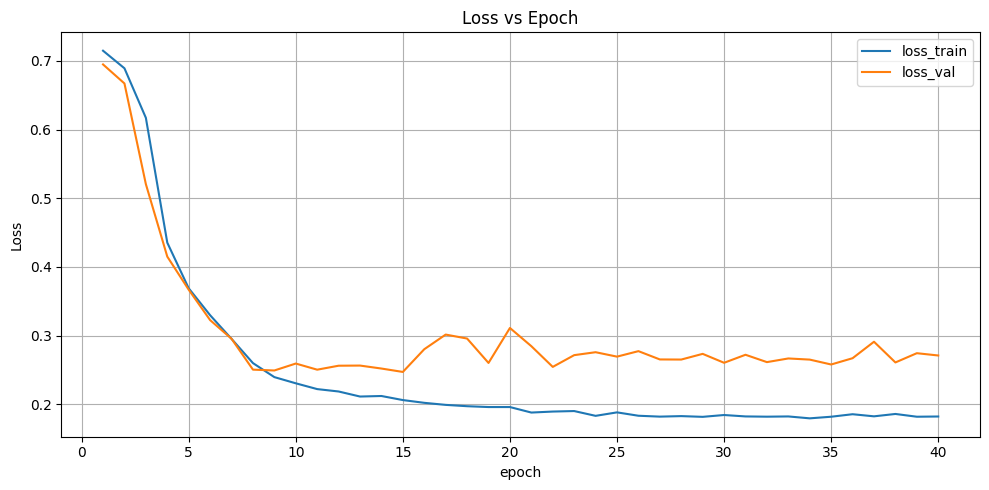

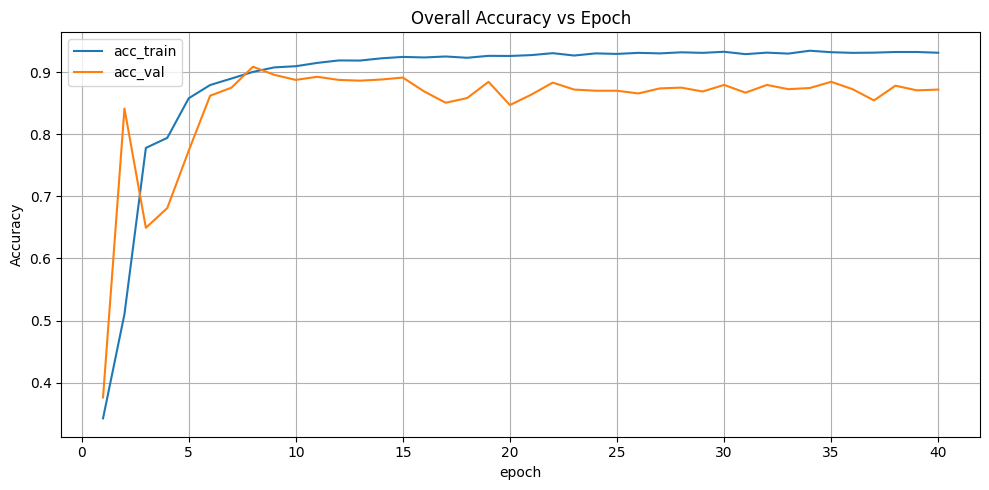

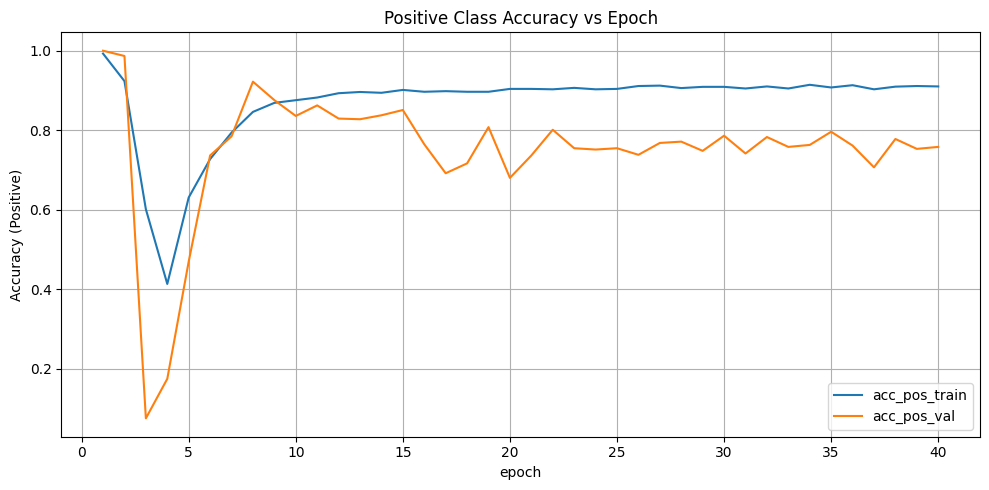

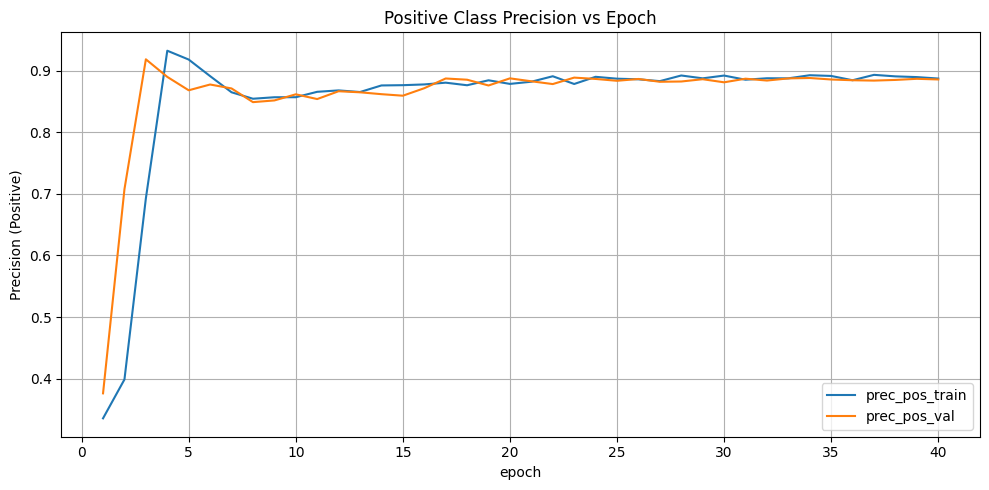

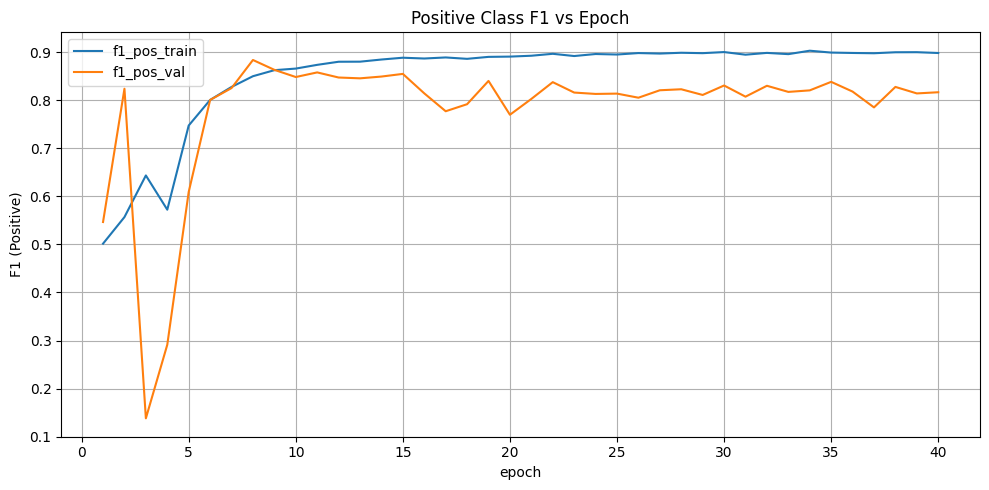

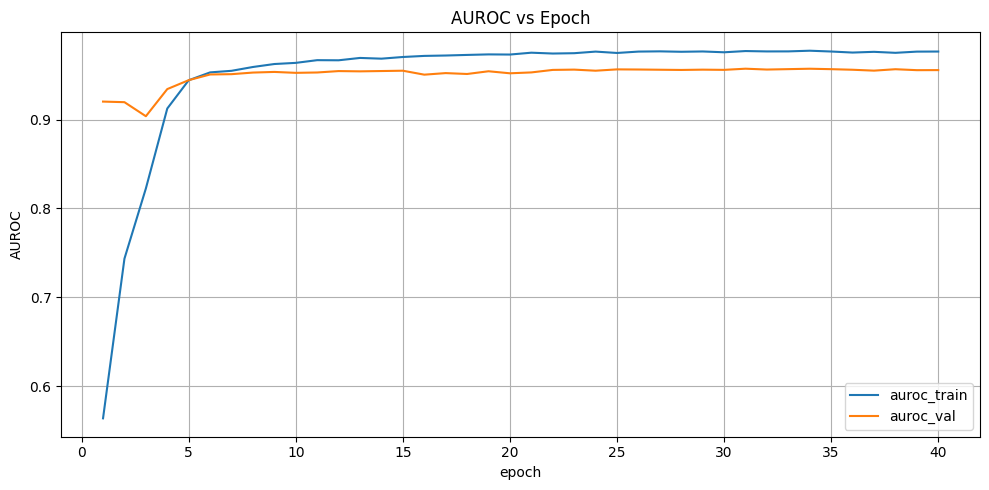

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from io import StringIO

path = "log/train/training_log.csv"

with open(path, "r") as f:
    lines = f.readlines()

header_idx = None
for i, line in enumerate(lines):
    if line.strip().startswith("epoch,"):
        header_idx = i
        break

if header_idx is None:
    raise ValueError("Header row starting with 'epoch,' not found.")

metrics_csv = "".join(lines[header_idx:])
df = pd.read_csv(StringIO(metrics_csv))

df.head()  # just to verify


def plot_metric(x, ys, title, ylabel):
    # Create save directory
    save_dir = "log/train/plots"
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(10, 5))

    for col in ys:
        if col in df.columns:
            plt.plot(df[x], df[col], label=col)

    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    filename = title.replace(" ", "_") + ".png"
    plt.savefig(os.path.join(save_dir, filename), dpi=300)

    # Show figure in notebook
    plt.show()


# 1. Loss
plot_metric("epoch", ["loss_train", "loss_val"], "Loss vs Epoch", "Loss")

# 2. Overall Accuracy
plot_metric("epoch", ["acc_train", "acc_val"], "Overall Accuracy vs Epoch", "Accuracy")

# 3. Positive Class Accuracy
plot_metric("epoch", ["acc_pos_train", "acc_pos_val"], 
            "Positive Class Accuracy vs Epoch", "Accuracy (Positive)")

# 4. Positive Class Precision
plot_metric("epoch", ["prec_pos_train", "prec_pos_val"], 
            "Positive Class Precision vs Epoch", "Precision (Positive)")

# 5. Positive Class F1
plot_metric("epoch", ["f1_pos_train", "f1_pos_val"], 
            "Positive Class F1 vs Epoch", "F1 (Positive)")

# 6. AUROC
plot_metric("epoch", ["auroc_train", "auroc_val"], 
            "AUROC vs Epoch", "AUROC")


In [28]:
def test():
    logger = get_logger(args, model='test')
    log_string(logger, "# testing samples: %d" % len(VAL_DATASET))
    log_string(logger, "\nloading the model ...")
    TEST_DATASET = FireDataLoader(root=args.data_dir, mode='test', is_scale=args.is_scale, neg_pos_ratio=args.neg_pos_ratio_val,
                                 val_year=args.val_year, negative=args.negative, nan_fill=args.nan_fill,
                                 is_aug=False, is_shuffle=False, lag=args.lag, dynamic_features=args.dynamic_features,
                                 static_features=args.static_features, seed=args.seed)
    testDataLoader = torch.utils.data.DataLoader(TEST_DATASET,
                                                 batch_size=args.batch_size,
                                                 shuffle=False,
                                                 pin_memory=args.pin_memory,
                                                 num_workers=args.n_workers)
    log_string(logger, "# testing samples: %d" % len(VAL_DATASET))
    log_string(logger, "\nloading the model ...")
    device = 'cuda'
    classifier = CNN(input_channels_d = len(args.dynamic_features),
                     input_channels_s = len(args.static_features),
                     input_channels_c = len(args.clc_features),
                     n_classes = 2,
                     drop_out = args.drop_out,
                     pe = args.PE,
                     device = device
                    ).to(device)
    log_string(logger, "model parameters: %d" % count_parameters(classifier))
    checkpoint = torch.load(args.model_dir, map_location='cpu')
    classifier.load_state_dict(checkpoint['model_state_dict'], strict=True)
    log_string(logger, 'testing on FireCube dataset ...\n')
    time.sleep(0.2)
    eval_val = evaluator(logger, 'Testing')
    with torch.no_grad():
        classifier = classifier.eval()
        loss_sum = 0
        time.sleep(0.2)
        for i, (data_s, data_d, data_c, target, data_t) in tqdm(enumerate(testDataLoader), total=len(testDataLoader),
                                                                smoothing=0.9, postfix="  validation"):

            data_s, data_d, data_c, data_t, target = torch.Tensor(data_s).float().to(device), \
                                                     torch.Tensor(data_d).float().to(device), \
                                                     torch.Tensor(data_c).float().to(device), \
                                                     torch.Tensor(data_t).to(device), \
                                                     torch.Tensor(target).long().to(device)
            
            pred = classifier(data_s, data_c, data_d, data_t)

            pred_prob = torch.exp(pred).cpu().numpy()
            eval_val(pred_prob, target.cpu().numpy())

        mean_loss_val = loss_sum / float(len(testDataLoader))
        eval_val.get_results(mean_loss_val, np.nan)

        time.sleep(0.1)

    eval_val.reset()

In [29]:
test()

Parameters ...
Namespace(model='CNN', batch_size=64, n_workers=10, pin_memory=True, seed=0, name='train', gpu_id=0, val_year=2021, negative='random', nan_fill=True, is_aug=True, is_scale=True, is_shuffle=True, lag=10, neg_pos_ratio_train=2, neg_pos_ratio_val=0, n_epochs=40, lr=3e-05, optimizer='Adam', weight_decay=0.02, drop_out=0.5, PE=True, lr_scheduler='StepLR', lr_step_size=23, lr_decay=0.1, e_save=2, data_dir='./output_aligned_patches', log_dir='./log', model_dir='log/train/model_checkpoints/best_loss_model.pth', dynamic_features=['relative_humidity', 'total_precipitation', 'dew_point_temperature', 'wind_speed', 'temperature'], static_features=['elevation', 'slope', 'population', 'water_proximity', 'road_proximity'], clc_features=['Water', 'Ice/Snow', 'Built-up Open/low', 'Built-up(medium/high)', 'Barren', 'Forest', 'Shrub/Scrub', 'Grass/pasture/Hay', 'Clutivated Crops', 'Wetlands'])
# testing samples: 1603

loading the model ...
# testing samples: 1603

loading the model ...
mode

100%|████████████████████████████| 52/52 [00:00<00:00, 110.38it/s,   validation]


-----------------   Testing   -----------------
class Background     weight: 0.9083, precision: 0.9682, accuracy: 0.9347, F1: 0.9512 IoU: 0.9069 
class Wildfire       weight: 0.0917, precision: 0.5184, accuracy: 0.6964, F1: 0.5944 IoU: 0.4228 

Testing accuracy      : 0.9128
Testing mean accuracy : 0.8155
Testing AUROC         : 0.9370
Testing mean IoU      : 0.6649
Testing mean F1       : 0.7728
Testing mean loss     : 0.0000    best mean loss     : nan


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)

In [ ]:
import numpy as np
arr = np.load("output_aligned_patches/positive/20200906_860_568_dynamic.npy")
print(arr.shape)

In [ ]:
!nvidia-smi

In [37]:
import os
from collections import defaultdict

def count_fire_instances_per_year(root):
    """
    Count number of fire (positive) and non-fire (negative) samples per year.
    root : str
        The dataset root directory. Must contain 'positive/' and 'negative/' subfolders.
    Returns:
    --------
    dict with structure:
    {
        year: {
            "positive": count,
            "negative": count
        }
    }
    """
    result = defaultdict(lambda: {"positive": 0, "negative": 0})

    for label_name in ["positive", "negative"]:
        folder = os.path.join(root, label_name)

        if not os.path.exists(folder):
            print(f"Warning: folder not found -> {folder}")
            continue

        for fname in os.listdir(folder):
            # We only care about dynamic.npy files
            if not fname.endswith("dynamic.npy"):
                continue

            # filenames look like: 20180821_123_456_dynamic.npy
            year_str = fname[:4]

            # skip weird files
            if not year_str.isdigit():
                continue

            year = int(year_str)

            result[year][label_name] += 1

    return dict(result)

In [38]:
root = "./output_aligned_patches"

counts = count_fire_instances_per_year(root)

for year in sorted(counts.keys()):
    print(year, "=>", counts[year])


2015 => {'positive': 180, 'negative': 1000}
2016 => {'positive': 109, 'negative': 1000}
2017 => {'positive': 278, 'negative': 1000}
2018 => {'positive': 358, 'negative': 1000}
2019 => {'positive': 43, 'negative': 1000}
2020 => {'positive': 967, 'negative': 1000}
2021 => {'positive': 603, 'negative': 1000}
2022 => {'positive': 31, 'negative': 1000}
2023 => {'positive': 48, 'negative': 1000}
2024 => {'positive': 224, 'negative': 1000}


In [ ]:
traindata = FireDataLoader(root=root, mode='train', is_scale=True, neg_pos_ratio=1, val_year=2021, negative='random',
                          nan_fill=0.0, is_aug=True, is_shuffle=False, lag=10, dynamic_features=dynamic_features,
                          static_features=static_features, seed=0)
validdata = FireDataLoader(root=root, mode='val', is_scale=True, neg_pos_ratio=1, val_year=2021, negative='random',
                          nan_fill=0.0, is_aug=True, is_shuffle=False, lag=10, dynamic_features=dynamic_features,
                          static_features=static_features, seed=0)
testdata = FireDataLoader(root=root, mode='test', is_scale=True, neg_pos_ratio=1, val_year=2021, negative='random',
                          nan_fill=0.0, is_aug=True, is_shuffle=False, lag=10, dynamic_features=dynamic_features,
                          static_features=static_features, seed=0)

print('number of sampled data:', traindata.__len__())
print('number of sampled data:', validdata.__len__())
print('number of sampled data:', testdata.__len__())